In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from utils.plotter import datacollector_realtest
import glob, re
from tqdm import tqdm
import corner
from scipy.stats import gaussian_kde

from tinygp import kernels
from tinygp import GaussianProcess
from functools import partial
import jax.numpy as jnp
import jax
from pioran import PSDToACV
from pioran.psd import OneBendPowerLaw
import warnings
from scipy.stats import lognorm
from matplotlib.ticker import FuncFormatter
from scipy.stats import mode

warnings.filterwarnings('ignore')



In [2]:
def load_json(file_path):
        with open(file_path) as json_file:
            return json.load(json_file)
        
def plot_corner(dictionary, exclude_keys=['log_Z_mean', 'log_Z_uncert']):
    if exclude_keys is None:
        exclude_keys = []

    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    data = np.array([array for array in filtered_data.values()]).T
    
    fig = corner.corner(data, bins=50 ,  labels=list(filtered_data.keys()), show_titles=True, title_kwargs={"fontsize": 12})
    
    plt.show()
    
def sort_arrays_together(time, flux, err=[None]):
        """
        Sorts two arrays (time and flux) together based on the values of the time array.

        Parameters:
        - time: array-like, array to be sorted
        - flux: array-like, corresponding flux values

        Returns:
        - sorted_time: array-like, sorted time array
        - sorted_flux: array-like, corresponding flux values sorted based on time
        """
        indices = np.argsort(time)
        sorted_time = time[indices]
        sorted_flux = flux[indices]
        if err[0]!=None:
            sorted_flux_err = err[indices]
            return sorted_time, sorted_flux, sorted_flux_err
        else:
            return sorted_time, sorted_flux
        
        
def sine_curve_model(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 


def sample_posterior_within_1sigma(param_samples_dict, num_samples, q = [0, 100]):
    param_names = list(param_samples_dict.keys())
    param_samples = np.array(list(param_samples_dict.values()))
    lower_quantiles, upper_quantiles = np.percentile(param_samples, q, axis=1)
    
    within_1sigma_mask = np.all((param_samples.T >= lower_quantiles) & (param_samples.T <= upper_quantiles), axis=1)
    filtered_samples = param_samples[:, within_1sigma_mask].T
    
    if len(filtered_samples) < num_samples:
        raise ValueError("Not enough samples within 1σ to draw the desired number of samples")
    
    sampled_indices = np.random.choice(filtered_samples.shape[0], size=num_samples, replace=False)
    sampled_params = filtered_samples[sampled_indices]
    
    if num_samples==1:
        sampled_values_dict = {param_names[i]: sampled_params[:, i][0] for i in range(len(param_names))}
    else:
        sampled_values_dict = {param_names[i]: sampled_params[:, i] for i in range(len(param_names))}
    
    return sampled_values_dict

def build_gp_DRW(theta, X, diag, mean_val = 0):

    amp = theta["amp"]
    scale= theta["scales"]
    err_scale = theta['err_scale']

    kernel = amp * kernels.Exp(scale = scale)
    
    return GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean= mean_val)


def build_gp_OBPL(theta, X, y, diag, mean_val = 0):

    amp = theta["amp"]
    alpha_l = theta["alpha_l"]
    alpha_h = theta["alpha_h"]
    scale= theta["scales"]
    err_scale = theta['err_scale']

    psd = OneBendPowerLaw([amp, alpha_l, 1/scale, alpha_h], free_parameters=[True]*4)
    
    model_ACV = PSDToACV(psd, S_low=100,
                S_high=20,
                T=X[-1] - X[0],
                dt=np.min(np.diff(X)),
                method='SHO',
                n_components=10,
                estimate_variance=True,
                init_variance=jnp.var(y, ddof=1),
                use_celerite=False,
                use_legacy_celerite=False )
    
    kernel = model_ACV.ACVF

    return GaussianProcess(kernel, X, diag=(diag*err_scale)**2, mean=mean_val)

def build_gp_CARMA21(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha0 = theta["log_alpha0"]
    log_alpha1 = theta["log_alpha1"]
    log_beta1 = theta["log_beta1"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1)])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp

def GPmaker(model, dicti, X, Y,  Yerr, mean=0):
    if 'DRW' in model:
        return build_gp_DRW(dicti, X, Yerr, mean_val=mean)
    elif 'CARMA' in model:
        return build_gp_CARMA21(dicti, X, Yerr, mean_val=mean)
    elif 'OBPL' in model:
        return build_gp_OBPL(dicti, X, Y, Yerr, mean_val=mean)
    
def meanval(model, dicti):
    if 'sine' in model:
        return partial(sine_curve_model, dicti)
    else:
         return 0

def LC_GP_plotter(model_dictiii, time, flux, flux_err, plot_samples=True, plot_what='all', fig_size = [10,6]):
    
    model_dict = model_dictiii.copy()
    model_dict.pop('log_Z_mean')
    model_dict.pop('log_Z_uncert')
    
    params = {}
    params_1sigma_lower = {}
    params_1sigma_upper = {}
    for (key, val) in model_dict.items():
        params[key], params_1sigma_lower[key], params_1sigma_upper[key] = np.percentile(val, [50, 16, 84])
         
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    print(params)
    
    
    x = np.linspace(min(time)-1, max(time)+1, 1000)
    
    if plot_samples:
        for i in tqdm(range(10), desc='Plotting samples from posteriors... '):
            sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
            # params_sample = {}
            # for (key, val) in sample_dict.items():
            #     params_sample[key] = np.percentile(val, [50])
                
            gp = GPmaker(plot_what, sample_dict, time, flux, flux_err, mean=meanval(plot_what, sample_dict))
            cond_gp = gp.condition(flux, x).gp
            mu, var = cond_gp.loc, cond_gp.variance
            if i ==0:
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
            else:
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
    
    if 'sine' in plot_what:
        for i in range(50):
            if i ==0:
                ax.plot(x, sine_curve_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84]), x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, sine_curve_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84]), x), 'r-', alpha = 0.2)
  
    gp = GPmaker(plot_what, params, time, flux, flux_err, mean=meanval(plot_what, params))
    cond_gp = gp.condition(flux, x).gp
    mu, var = cond_gp.loc, cond_gp.variance
    ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
    ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
    
    plt.xlim(min(x), max(x))
    plt.ylim(min(flux) - np.std(flux)*2, max(flux) + np.std(flux)*2)
    plt.legend()
    plt.grid()
    plt.ylabel(r'$Flux\;[arbitary\;units]$', fontsize = 14)
    plt.xlabel(r'$Time\;[years]$', fontsize = 14)
    plt.tick_params(labelsize = 11)
    plt.tight_layout()

    plt.show()

def LC_GPdict_plotter(model_dict, time, flux, flux_err, plot_samples=True, plot_what='all'):
    
    model_dict.pop('log_Z_mean')
    model_dict.pop('log_Z_uncert')
    
    params = {}
    params_1sigma_lower = {}
    params_1sigma_upper = {}
    for (key, val) in model_dict.items():
        params[key], params_1sigma_lower[key], params_1sigma_upper[key] = np.percentile(val, [50, 16, 84])
         
    fig, ax = plt.subplots(1,1,figsize=[10,6])
    print(params)
    
    if plot_what == 'DRW':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_DRW(sample_dict, time, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
        
        gp = build_gp_DRW(params, time, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'DRWsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_DRW(sample_dict, time, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2)
    
        
        for i in range(50):
            if i ==0:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=1, label = 'Data')
        gp = build_gp_DRW(params, time, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        
    elif plot_what == 'CARMA':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_CARMA21(sample_dict, time, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
        
        gp = build_gp_CARMA21(params, time, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'CARMAsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_CARMA21(sample_dict, time, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2)
    
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=0.2, label = 'Data')
        gp = build_gp_CARMA21(params, time, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        for i in range(50):
            if i ==0:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'OBPL':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in tqdm(range(10)):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_OBPL(sample_dict, time, flux, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
        
        gp = build_gp_OBPL(params, time, flux, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'OBPLsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in tqdm(range(10)):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_OBPL(sample_dict, time, flux, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2)
    
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=0.2, label = 'Data')
        gp = build_gp_OBPL(params, time, flux, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        for i in range(50):
            if i ==0:
                
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[5, 95])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[5, 95])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
    
    plt.tight_layout()
    plt.xlim(min(x), max(x))
    plt.ylim(min(flux) - np.std(flux)*3, max(flux) + np.std(flux)*3)
    plt.legend()
    plt.grid()
    plt.ylabel(r'$Flux\;[arbitary\;units]$', fontsize = 14)
    plt.xlabel(r'$Time\;[years]$', fontsize = 14)
    plt.tick_params(labelsize = 11)
    plt.show()
    del time, flux, flux_err, #DRW_results, DRW_sine_results, gp, cond_gp, params

# Graham data PG 1302-102

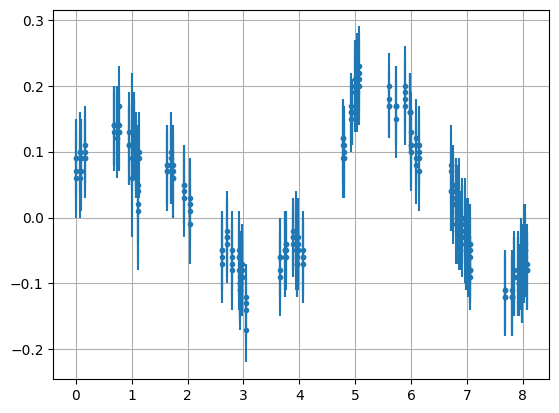

In [3]:
LCdata = pd.read_csv('AGNobsdata/graham2015data.csv')
LCdata['years'] = (LCdata.MJD.to_numpy())/365
lcTIME = LCdata.years.to_numpy()
lcFLUX = LCdata.Mag.to_numpy() - np.median(LCdata.Mag.to_numpy())
lcFLUXerr = LCdata.Magerr.to_numpy()

lcTIME, lcFLUX, lcFLUXerr = sort_arrays_together(lcTIME, lcFLUX, lcFLUXerr)
lcTIME = lcTIME -lcTIME[0]

plt.errorbar(lcTIME, lcFLUX, yerr=lcFLUXerr, fmt = '.')
plt.grid()

In [34]:
org_DRW_dict = load_json('real_data_tests/final/PG1302_102/original_data_DRW.json')
org_DRWsine_dict = load_json('real_data_tests/final/PG1302_102//original_data_DRWsine.json')

# org_CARMA21_dict = load_json('real_data_tests/final/PG1302_102/original_data_CARMA21.json')
# org_CARMA21sine_dict = load_json('real_data_tests/final/PG1302_102//original_data_CARMA21sine.json')


org_OBPL10_dict = load_json('real_data_tests/final/PG1302_102//original_data_OBPL10.json')
org_OBPL10sine_dict = load_json('real_data_tests/final/PG1302_102//original_data_OBPL10sine.json')


# org_DRW_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_DRW.json')
# org_DRWsine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_DRWsine.json')

org_CARMA21_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_CARMA21.json')
org_CARMA21sine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_CARMA21sine.json')


# org_OBPL10_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_OBPL10.json')
# org_OBPL10sine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_OBPL10sine.json')

# org_DRW_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_amp_weirdprior_testDRW.json')
# org_DRWsine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_amp_weirdprior_testDRWsine.json')

# org_CARMA21_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_amp_weirdprior_testCARMA21.json')
# org_CARMA21sine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_amp_weirdprior_testCARMA21sine.json')


# org_OBPL10_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_amp_weirdprior_testOBPL10.json')
# org_OBPL10sine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_amp_weirdprior_testOBPL10sine.json')



# org_DRW_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4DRW.json')
# org_DRWsine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4DRWsine.json')

# org_CARMA21_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4CARMA21.json')
# org_CARMA21sine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4CARMA21sine.json')


# org_OBPL10_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4OBPL10.json')
# org_OBPL10sine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4OBPL10sine.json')





In [35]:
org_DRW_dict['log_Z_mean'],org_DRWsine_dict['log_Z_mean'],org_OBPL10_dict['log_Z_mean'],org_OBPL10sine_dict['log_Z_mean']

(744.1278925964516, 747.5080292320239, 742.8425562455868, 753.0762829383722)

In [36]:
print( np.log10(np.exp(org_DRW_dict['log_Z_mean'] - org_DRWsine_dict['log_Z_mean'])) ) 
print( np.log10(np.exp(org_OBPL10_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])) ) 
print( np.log10(np.exp(org_DRWsine_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])) )

print('\n')
print( 10**np.log10(np.exp(org_DRW_dict['log_Z_mean'] - org_DRWsine_dict['log_Z_mean'])) ) 
print( 10**np.log10(np.exp(org_OBPL10_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])) ) 
print( 10**np.log10(np.exp(org_DRWsine_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])) )


-1.467974688908066
-4.444451031982694
-2.418261858504391


0.0340428029589431
3.5937591519321357e-05
0.0038171404638741224


In [37]:


def plot_corner(dictionary: dict, log_scale_keys: list = None, exclude_keys: list = ['log_Z_mean', 'log_Z_uncert']):
    """
    Create a corner plot from a dictionary of data arrays.

    Parameters:
    - dictionary (dict): Dictionary containing data arrays to plot.
    - log_scale_keys (list): Keys of the dictionary to apply log scale. Defaults to None.
    - exclude_keys (list): Keys to exclude from the plot. Defaults to ['log_Z_mean', 'log_Z_uncert'].

    Returns:
    - fig: The figure object containing the corner plot.
    - axes: The axes object for the subplots.
    """
    if exclude_keys is None:
        exclude_keys = []
    if log_scale_keys is None:
        log_scale_keys = []

    # Define the key renaming mapping
    key_mapping = {
        'A1': '$A_1$',
        'A2': '$A_2$',
        't0': '$T_{period}$',
        'scales': '$log_{10}(f_{bend})$',
        'amp': '$log_{10}(A)$',
        'err_scale': '$\\nu$',
        'alpha_l' : '$\\alpha_l$',
        'alpha_h' : '$\\alpha_h$'
    }

    # Filter the dictionary
    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    # Transform specified keys to log scale
    for key in log_scale_keys:
        if key in filtered_data:
            filtered_data[key] = np.log10(filtered_data[key])
            filtered_data[key] = np.where(filtered_data[key] == -np.inf, np.nan, filtered_data[key])  # Handle -inf values

    # Rename keys based on the mapping
    renamed_data = {key_mapping.get(key, key): value for key, value in filtered_data.items()}

    # Prepare the data for plotting
    data = np.array([array for array in renamed_data.values()]).T

    # Create the corner plot
    fig = corner.corner(data, bins=50, labels=list(renamed_data.keys()), show_titles=True, title_kwargs={"fontsize": 14}, label_kwargs={'fontsize':18})

    # Accessing each subplot individually
    axes = np.array(fig.axes).reshape((len(renamed_data), len(renamed_data)))

     # Calculate modes for each subplot
    modes = {}
    num_params = len(renamed_data)

    for i in range(num_params):
        for j in range(num_params):
            if i == j:
                # Diagonal subplots: mode of the histogram for the single parameter
                key = list(renamed_data.keys())[i]
                hist, bins = np.histogram(renamed_data[key], bins=50)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                peak_value = bin_centers[np.argmax(hist)]
                modes[(i, j)] = (peak_value, peak_value)  # Mode is the same for both x and y
            else:
                # Off-diagonal subplots: mode of the histogram for x and y directions
                x_peak = mode(data[:, j], nan_policy='omit').mode
                y_peak = mode(data[:, i], nan_policy='omit').mode
                modes[(i, j)] = (x_peak, y_peak)

            


    # Customize the plot to reflect log scaling in labels
    def log_formatter(val, pos):
        return r"$10^{{{:.0f}}}$".format(val)
    for i, key in enumerate(renamed_data.keys()):
        if key in [key_mapping.get(k, k) for k in log_scale_keys]:  # Check if renamed key is in log_scale_keys
            for j in range(len(renamed_data)):
                if i == j:
                    ax = axes[i, j]
                    #ax.set_title(f"log10({key})", fontsize=12)
                    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))
                    ax.yaxis.set_major_formatter(FuncFormatter(log_formatter))
                    axes[-1, j].set_xlabel(f"{key}", fontsize=18)
                    axes[-1, j].xaxis.set_major_formatter(FuncFormatter(log_formatter))
                    axes[i, 0].set_ylabel(f"{key}", fontsize=18)
                    axes[i, 0].yaxis.set_major_formatter(FuncFormatter(log_formatter))
                    
                    # Calculate and display percentiles
                    percentiles = np.percentile(renamed_data[key], [16, 50, 84])
                    if key == '$log_{10}(f_{bend})$':
                        ax.set_title(f"{key}$={percentiles[1]:.2f}^{{+{percentiles[2]-percentiles[1]:.2f}}}_{{-{percentiles[1]-percentiles[0]:.2f}}}$", fontsize=12.5)    
                    else:
                        ax.set_title(f"{key}$={percentiles[1]:.2f}^{{+{percentiles[2]-percentiles[1]:.2f}}}_{{-{percentiles[1]-percentiles[0]:.2f}}}$", fontsize=14)

    # for i in range(num_params):
    #     for j in range(num_params):
    #         if i>j:
    #             ax = axes[i, j]
    #             ax.axvline(modes[(i, j)][0])   
    #             ax.axhline(modes[(i, j)][1])           
    
    plt.show()
    return fig, axes


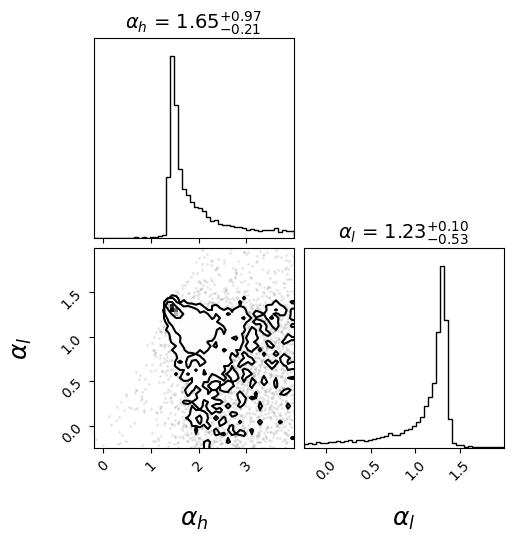

In [38]:
_ = plot_corner(org_OBPL10sine_dict, log_scale_keys=['amp', 'scales'], exclude_keys=['log_Z_mean', 'log_Z_uncert', 'A1', 'A2', 'scales', 'amp', 'err_scale', 't0'])

In [39]:
def sine_curve_model(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 


def sample_posterior_within_1sigma(param_samples_dict, num_samples, q = [0, 100]):
    param_names = list(param_samples_dict.keys())
    param_samples = np.array(list(param_samples_dict.values()))
    lower_quantiles, upper_quantiles = np.percentile(param_samples, q, axis=1)
    
    within_1sigma_mask = np.all((param_samples.T >= lower_quantiles) & (param_samples.T <= upper_quantiles), axis=1)
    filtered_samples = param_samples[:, within_1sigma_mask].T
    
    if len(filtered_samples) < num_samples:
        raise ValueError("Not enough samples within 1σ to draw the desired number of samples")
    
    sampled_indices = np.random.choice(filtered_samples.shape[0], size=num_samples, replace=False)
    sampled_params = filtered_samples[sampled_indices]
    
    if num_samples==1:
        sampled_values_dict = {param_names[i]: sampled_params[:, i][0] for i in range(len(param_names))}
    else:
        sampled_values_dict = {param_names[i]: sampled_params[:, i] for i in range(len(param_names))}
    
    return sampled_values_dict

def build_gp_DRW(theta, X, diag, mean_val = 0):

    amp = theta["amp"]
    scale= theta["scales"]
    err_scale = theta['err_scale']

    kernel = amp * kernels.Exp(scale = scale)
    
    return GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean= mean_val)


def build_gp_OBPL(theta, X, y, diag, mean_val = 0):

    amp = theta["amp"]
    alpha_l = theta["alpha_l"]
    alpha_h = theta["alpha_h"]
    scale= theta["scales"]
    err_scale = theta['err_scale']

    psd = OneBendPowerLaw([amp, alpha_l, 1/scale, alpha_h], free_parameters=[True]*4)
    
    model_ACV = PSDToACV(psd, S_low=100,
                S_high=20,
                T=X[-1] - X[0],
                dt=np.min(np.diff(X)),
                method='SHO',
                n_components=10,
                estimate_variance=True,
                init_variance=jnp.var(y, ddof=1),
                use_celerite=False,
                use_legacy_celerite=False )
    
    kernel = model_ACV.ACVF

    return GaussianProcess(kernel, X, diag=(diag*err_scale)**2, mean=mean_val)

def build_gp_CARMA21(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha0 = theta["log_alpha0"]
    log_alpha1 = theta["log_alpha1"]
    log_beta1 = theta["log_beta1"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1)])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp

def GPmaker(model, dicti, X, Y,  Yerr, mean=0):
    if 'DRW' in model:
        return build_gp_DRW(dicti, X, Yerr, mean_val=mean)
    elif 'CARMA' in model:
        return build_gp_CARMA21(dicti, X, Yerr, mean_val=mean)
    elif 'OBPL' in model:
        return build_gp_OBPL(dicti, X, Y, Yerr, mean_val=mean)
    
def meanval(model, dicti):
    if 'sine' in model:
        return partial(sine_curve_model, dicti)
    else:
         return 0

def LC_GP_plotter(model_dictiii, time, flux, flux_err, plot_samples=True, plot_what='all', fig_size =[10, 6] ):
    
    model_dict = model_dictiii.copy()
    model_dict.pop('log_Z_mean')
    model_dict.pop('log_Z_uncert')
    
    params = {}
    params_1sigma_lower = {}
    params_1sigma_upper = {}
    for (key, val) in model_dict.items():
        params[key], params_1sigma_lower[key], params_1sigma_upper[key] = np.percentile(val, [50, 16, 84])
         
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    print(params)
    
    
    x = np.linspace(min(time)-1, max(time)+1, 1000)
    
    if plot_samples:
        print(1)
        for i in tqdm(range(10), desc='Plotting samples from posteriors... '):
            sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
            # params_sample = {}
            # for (key, val) in sample_dict.items():
            #     params_sample[key] = np.percentile(val, [50])
                
            gp = GPmaker(plot_what, sample_dict, time, flux, flux_err, mean=meanval(plot_what, sample_dict))
            cond_gp = gp.condition(flux, x).gp
            mu, var = cond_gp.loc, cond_gp.variance
            if i ==0:
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(np.random.randint(0, 1000))), "b-", lw=1, alpha=0.3, label = 'samples from posterior')
            else:
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(np.random.randint(0, 1000))), "b-", lw=1, alpha=0.3,)
    
    if True:
        if 'sine' in plot_what:
            for i in range(50):
                if i ==0:
                    ax.plot(x, sine_curve_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16,84]), x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
                else:
                    ax.plot(x, sine_curve_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16,84]), x), 'r-', alpha = 0.2)
    
    gp = GPmaker(plot_what, params, time, flux, flux_err, mean=meanval(plot_what, params))
    cond_gp = gp.condition(flux, x).gp
    mu, var = cond_gp.loc, cond_gp.variance
    ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
    ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="y", alpha=0.7, label = r'$1\sigma\;err$')
    
    plt.xlim(min(x), max(x))
    plt.ylim(min(flux) - np.std(flux)*2, max(flux) + np.std(flux)*2)
    plt.legend(fontsize = 13)
    plt.grid()
    plt.ylabel(r'$Normalised\;Flux$', fontsize = 16)
    plt.xlabel(r'$Time\;[years]$', fontsize = 16)
    plt.tick_params(labelsize = 12)
    plt.tight_layout()

    plt.show()

def LC_GPdict_plotter(model_dict, time, flux, flux_err, plot_samples=True, plot_what='all'):
    
    model_dict.pop('log_Z_mean')
    model_dict.pop('log_Z_uncert')
    
    params = {}
    params_1sigma_lower = {}
    params_1sigma_upper = {}
    for (key, val) in model_dict.items():
        params[key], params_1sigma_lower[key], params_1sigma_upper[key] = np.percentile(val, [50, 16, 84])
         
    fig, ax = plt.subplots(1,1,figsize=[10,6])
    print(params)
    
    if plot_what == 'DRW':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_DRW(sample_dict, time, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.4, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.4,)
        
        gp = build_gp_DRW(params, time, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'DRWsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_DRW(sample_dict, time, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.4)
    
        
        for i in range(50):
            if i ==0:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=1, label = 'Data')
        gp = build_gp_DRW(params, time, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        
    elif plot_what == 'CARMA':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_CARMA21(sample_dict, time, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.4, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.4,)
        
        gp = build_gp_CARMA21(params, time, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'CARMAsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_CARMA21(sample_dict, time, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2)
    
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=0.2, label = 'Data')
        gp = build_gp_CARMA21(params, time, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        for i in range(50):
            if i ==0:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'OBPL':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in tqdm(range(10)):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_OBPL(sample_dict, time, flux, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.4, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.4,)
        
        gp = build_gp_OBPL(params, time, flux, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'OBPLsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in tqdm(range(10)):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_OBPL(sample_dict, time, flux, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.4)
    
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=0.2, label = 'Data')
        gp = build_gp_OBPL(params, time, flux, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        if False:
            for i in range(50):
                if i ==0:
                    
                    ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
                else:
                    ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2)
            ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
    
    plt.tight_layout()
    plt.xlim(min(x), max(x))
    plt.ylim(min(flux) - np.std(flux)*3, max(flux) + np.std(flux)*3)
    plt.legend()
    plt.grid()
    plt.ylabel(r'$Flux\;[arbitary\;units]$', fontsize = 14)
    plt.xlabel(r'$Time\;[years]$', fontsize = 14)
    plt.tick_params(labelsize = 11)
    plt.show()
    del time, flux, flux_err, #DRW_results, DRW_sine_results, gp, cond_gp, params

{'amp': 0.010613972839521382, 'err_scale': 0.21432496181870717, 'scales': 1.5048680245918786}
1


Plotting samples from posteriors... : 100%|██████████| 10/10 [00:01<00:00,  9.75it/s]


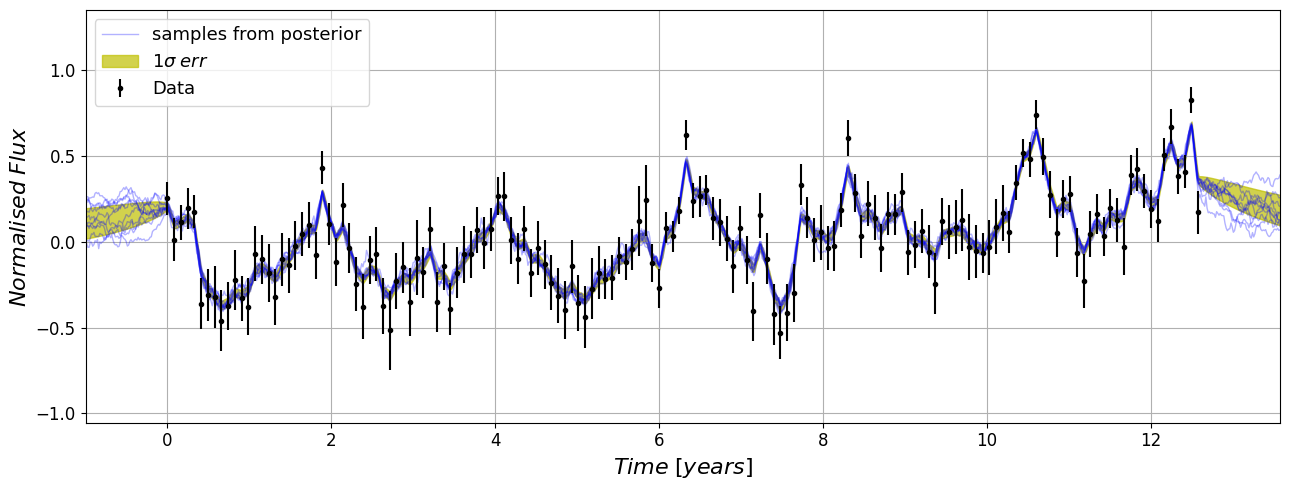

In [40]:
LC_GP_plotter(org_DRW_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='DRW', plot_samples=True, fig_size=[13,5])

{'alpha_h': 1.8766242712959254, 'alpha_l': 0.23423986787555623, 'amp': 0.021120589549099858, 'err_scale': 0.21226610042609678, 'scales': 5.494648373312721}
1


Plotting samples from posteriors... : 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


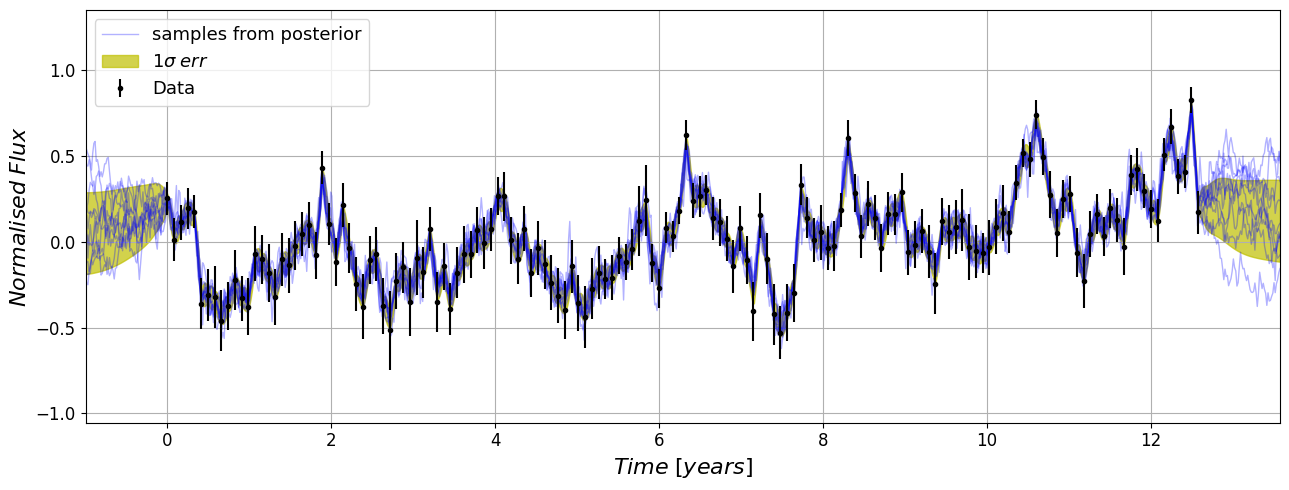

In [41]:
LC_GP_plotter(org_OBPL10_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='OBPL', fig_size=[13,5])

In [42]:
def datacollector_realtest(json_files_path):
    #datafile = pd.read_csv(csv_file_path)
    
    DRW_filenames = glob.glob(json_files_path + '/*[0-9]_DRW.*'); DRW_filenames.sort()
    DRWsine_filenames = glob.glob(json_files_path + '/*[0-9]_DRWsine.*'); DRWsine_filenames.sort()
    OBPL10_filenames = glob.glob(json_files_path + '/*[0-9]_OBPL.*'); OBPL10_filenames.sort()
    OBPLsine10_filenames = glob.glob(json_files_path+'/*[0-9]_OBPLsine.*'); OBPLsine10_filenames.sort()
    
    print(len(DRW_filenames),  len(DRWsine_filenames), len(OBPL10_filenames), len(OBPLsine10_filenames))
    
    # DRW_IDs, DRWsine_IDs, CARMA21_IDs, CARMA21sine_IDs, OBPL10_IDs, OBPLsine10_IDs = [],[],[],[],[],[]
    DRW_IDs, DRWsine_IDs, OBPL10_IDs, OBPLsine10_IDs = [],[],[],[]
    
    for val in zip(DRW_filenames, DRWsine_filenames, OBPL10_filenames, OBPLsine10_filenames):
        DRW_IDs.append(int(re.search('/[0-9]*[0-9]*[0-9]*[0-9]*[0-9]_',val[0]).group()[1:-1]))
        DRWsine_IDs.append(int(re.search('/[0-9]*[0-9]*[0-9]*[0-9]*[0-9]_',val[1]).group()[1:-1]))
        OBPL10_IDs.append(int(re.search('/[0-9]*[0-9]*[0-9]*[0-9]*[0-9]_',val[2]).group()[1:-1]))
        OBPLsine10_IDs.append(int(re.search('/[0-9]*[0-9]*[0-9]*[0-9]*[0-9]_',val[3]).group()[1:-1]))

    print('Collected all json files...')


    
    def load_json(file_path):
        with open(file_path) as json_file:
            return json.load(json_file)
        
    datafile = pd.DataFrame({'ID':DRW_IDs})
    
    columns_to_drop = ['DRW_log_Z_mean', 'DRW_log_Z_uncert', 'DRWsine_log_Z_mean', 'DRWsine_log_Z_uncert', 'OBPL10_log_Z_mean', 'OBPL10_log_Z_uncert', 'OBPLsine10_log_Z_mean','OBPLsine10_log_Z_uncert' ,
                            'DRW_bf', 'DRWsine_bf', 'OBPL10_bf', 'OBPLsine10_bf' ]
    
    datafile.drop(columns=columns_to_drop, errors='ignore', inplace=True)
    
    update_data = {
    'ID': [],
    'DRW_log_Z_mean': [], 'DRW_log_Z_uncert': [],
    'DRWsine_log_Z_mean': [], 'DRWsine_log_Z_uncert': [],
    'OBPL10_log_Z_mean': [], 'OBPL10_log_Z_uncert': [], 'OBPL10_alpha_h':[],'OBPL10_alpha_l':[],'OBPL10_alpha_l_84':[], 'OBPL10_alpha_l_16':[], 'OBPL10_alpha_h_84':[], 'OBPL10_alpha_h_16':[],
    'OBPLsine10_log_Z_mean': [], 'OBPLsine10_log_Z_uncert': [], 'OBPLsine10_alpha_h':[], 'OBPLsine10_alpha_l':[], 'OBPLsine10_alpha_l_84':[], 'OBPLsine10_alpha_l_16':[], 'OBPLsine10_alpha_h_84':[], 'OBPLsine10_alpha_h_16':[] }
    
    for i in tqdm(range(len(DRW_filenames)), desc = 'Gathering data from json files to dataframe'):
        
        val = DRW_filenames[i], DRWsine_filenames[i], OBPL10_filenames[i], OBPLsine10_filenames[i]
        ID = int(re.search('[0-9]*[0-9]*[0-9]*[0-9]*[0-9]_',val[0]).group()[:-1])
        
        DRW_dict = load_json(val[0])
        DRWsine_dict = load_json(val[1])
        OBPL10_dict = load_json(val[2])
        OBPLsine10_dict = load_json(val[3])
        
        update_data['ID'].append(ID)
        update_data['DRW_log_Z_mean'].append(DRW_dict['log_Z_mean'])
        update_data['DRW_log_Z_uncert'].append(DRW_dict['log_Z_uncert'])
        #update_data['DRW_bf'].append(np.power(10, np.median(DRW_dict['log_bend_freq'])))
    
        update_data['DRWsine_log_Z_mean'].append(DRWsine_dict['log_Z_mean'])
        update_data['DRWsine_log_Z_uncert'].append(DRWsine_dict['log_Z_uncert'])
        #update_data['DRWsine_bf'].append(np.power(10, np.median(DRWsine_dict['log_bend_freq'])))
        
        update_data['OBPL10_log_Z_mean'].append(OBPL10_dict['log_Z_mean'])
        update_data['OBPL10_log_Z_uncert'].append(OBPL10_dict['log_Z_uncert'])
        update_data['OBPL10_alpha_h'].append(np.percentile(OBPL10_dict['alpha_h'], q=[50])[0])
        update_data['OBPL10_alpha_h_16'].append(np.percentile(OBPL10_dict['alpha_h'], q=[16])[0])
        update_data['OBPL10_alpha_h_84'].append(np.percentile(OBPL10_dict['alpha_h'], q=[84])[0])
        update_data['OBPL10_alpha_l'].append(np.percentile(OBPL10_dict['alpha_l'], q=[50])[0])
        update_data['OBPL10_alpha_l_16'].append(np.percentile(OBPL10_dict['alpha_l'], q=[16])[0])
        update_data['OBPL10_alpha_l_84'].append(np.percentile(OBPL10_dict['alpha_l'], q=[84])[0])
        #update_data['OBPL10_bf'].append(np.power(10, np.median(OBPL10_dict['log_bend_freq'])))
        
        update_data['OBPLsine10_log_Z_mean'].append(OBPLsine10_dict['log_Z_mean'])
        update_data['OBPLsine10_log_Z_uncert'].append(OBPLsine10_dict['log_Z_uncert'])
        update_data['OBPLsine10_alpha_h'].append(np.percentile(OBPLsine10_dict['alpha_h'], q=[50])[0])
        update_data['OBPLsine10_alpha_h_16'].append(np.percentile(OBPLsine10_dict['alpha_h'], q=[16])[0])
        update_data['OBPLsine10_alpha_h_84'].append(np.percentile(OBPLsine10_dict['alpha_h'], q=[84])[0])
        update_data['OBPLsine10_alpha_l'].append(np.percentile(OBPLsine10_dict['alpha_l'], q=[50])[0])
        update_data['OBPLsine10_alpha_l_16'].append(np.percentile(OBPLsine10_dict['alpha_l'], q=[16])[0])
        update_data['OBPLsine10_alpha_l_84'].append(np.percentile(OBPLsine10_dict['alpha_l'], q=[84])[0])
        #update_data['OBPLsine10_bf'].append(np.power(10, np.median(OBPLsine10_dict['log_bend_freq'])))
        
    update_df = pd.DataFrame(update_data)

    datafile = datafile.merge(update_df, on='ID', how='right', suffixes=(None, '_new'))
    
    datafile['DRW_DRWsine_bayes'] = np.exp(datafile.DRW_log_Z_mean - datafile.DRWsine_log_Z_mean)
    datafile['OBPL10_OBPLsine10_bayes'] = np.exp(datafile.OBPL10_log_Z_mean - datafile.OBPLsine10_log_Z_mean)
    
    datafile[['DRWsine_bool','OBPLsine_bool',]] = 0, 0
    bayes_threshold = 2
    for i, row in datafile.iterrows():
        if np.log10(row.DRW_DRWsine_bayes)<(-1 * bayes_threshold):
            datafile.loc[datafile.ID == row.ID,'DRWsine_bool'] = 1
        if np.log10(row.DRW_DRWsine_bayes)>bayes_threshold:
            datafile.loc[datafile.ID == row.ID,'DRWsine_bool'] = -1
        if np.log10(row.OBPL10_OBPLsine10_bayes)<(-1 * bayes_threshold):
            datafile.loc[datafile.ID == row.ID,'OBPLsine_bool'] = 1
        if np.log10(row.OBPL10_OBPLsine10_bayes)>bayes_threshold:
            datafile.loc[datafile.ID == row.ID,'OBPLsine_bool'] = -1
    
    datafile.sort_values(by='ID', inplace=True)
    datafile.reset_index(inplace=True, drop=True)
    
    
    return datafile.copy()

In [43]:
Bayes_test_nosinehyp = datacollector_realtest(json_files_path='real_data_tests/final/PG1302_102/noperiod/')
Bayes_test_sinehyp = datacollector_realtest(json_files_path='real_data_tests/final/PG1302_102/period/')

500 500 500 500
Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 500/500 [00:45<00:00, 10.97it/s]


498 498 498 498
Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 498/498 [00:37<00:00, 13.21it/s]


In [44]:
org_OBPL10_OBPL10sine_bayes_factor = np.exp(org_OBPL10_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])
org_DRW_DRWsine_bayes_factor = np.exp(org_DRW_dict['log_Z_mean'] - org_DRWsine_dict['log_Z_mean'])


In [45]:
Bayes_test_nosinehyp

,ID,DRW_log_Z_mean,DRW_log_Z_uncert,DRWsine_log_Z_mean,DRWsine_log_Z_uncert,OBPL10_log_Z_mean,OBPL10_log_Z_uncert,OBPL10_alpha_h,OBPL10_alpha_l,OBPL10_alpha_l_84,...,OBPLsine10_alpha_h,OBPLsine10_alpha_l,OBPLsine10_alpha_l_84,OBPLsine10_alpha_l_16,OBPLsine10_alpha_h_84,OBPLsine10_alpha_h_16,DRW_DRWsine_bayes,OBPL10_OBPLsine10_bayes,DRWsine_bool,OBPLsine_bool
0,1302,619.802636,0.161770,617.934125,0.176307,622.558344,0.144239,1.862539,-0.059019,0.450448,...,1.834234,0.045821,0.354511,-0.144864,2.278626,1.677683,6.478644,10.377201,1,-1
1,1302,701.094584,0.129147,699.954567,0.151016,700.170258,0.131656,2.263648,-0.050934,0.562340,...,2.273678,0.137440,0.713464,-0.178288,2.948263,1.920458,3.126819,3.720729,1,-1
2,1302,644.748350,0.155004,643.057586,0.170018,649.419521,0.132368,1.782571,0.067402,0.487040,...,1.707955,0.167137,0.505031,-0.093305,2.448996,1.483064,5.423621,9.780192,1,-1
3,1302,657.409283,0.139692,655.929448,0.160884,658.663287,0.131297,1.711760,-0.040027,0.508227,...,1.829146,0.097238,0.451270,-0.177478,2.682420,1.528016,4.392222,4.493189,1,-1
4,1302,604.663523,0.142161,605.240422,0.167365,606.297108,0.130526,1.659864,0.007010,0.514446,...,1.639794,0.150161,0.438523,-0.056164,2.131045,1.527780,0.561638,1.116056,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1302,639.242240,0.158770,638.061400,0.173898,641.358433,0.141893,1.944235,0.005852,0.468905,...,1.971536,0.091850,0.397130,-0.162273,2.678156,1.735722,3.257108,4.801563,1,-1
496,1302,784.708669,0.140901,784.210960,0.160824,782.582293,0.136766,2.810066,0.870047,1.044319,...,3.271977,1.012855,1.091685,0.674783,3.763367,2.349270,1.644949,0.084926,1,-1
497,1302,619.782178,0.177992,618.519562,0.195813,625.136613,0.145808,1.825845,0.151970,0.476197,...,1.691639,0.113866,0.448618,-0.137627,2.017619,1.497933,3.534656,8.534022,1,-1
498,1302,520.249717,0.111456,518.509556,0.159870,522.081120,0.103719,2.891089,0.949685,1.012877,...,2.443441,0.941553,1.130749,0.509423,3.450498,1.763198,5.698262,13.978873,1,-1


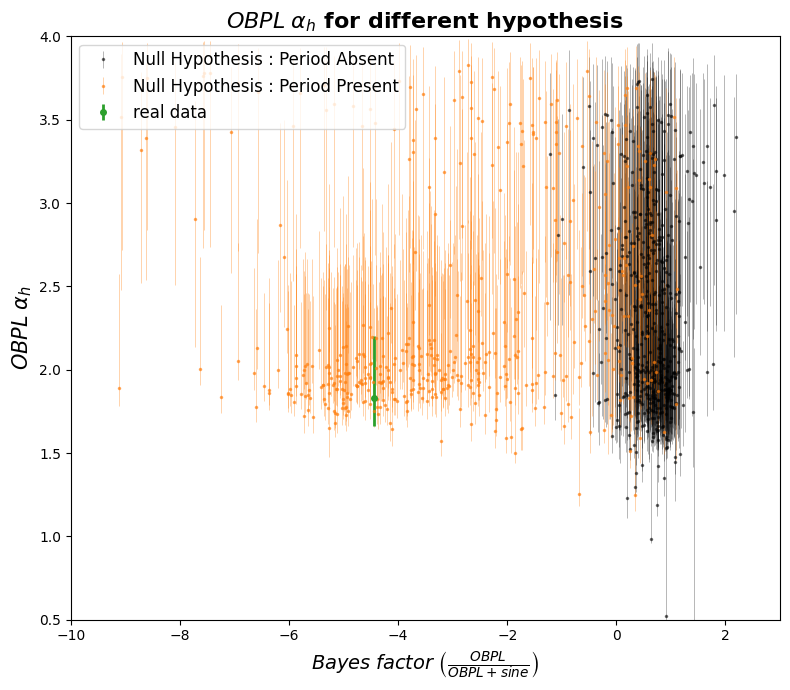

In [46]:
plt.figure(figsize = [8, 7])
plt.errorbar(np.log10(Bayes_test_nosinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_nosinehyp['OBPL10_alpha_h'], 
             yerr = [Bayes_test_nosinehyp['OBPL10_alpha_h'] - Bayes_test_nosinehyp['OBPL10_alpha_h_16'],
                     Bayes_test_nosinehyp['OBPL10_alpha_h_84'] - Bayes_test_nosinehyp['OBPL10_alpha_h']], 
             fmt = '.', elinewidth=0.4, ecolor = 'k', markersize = 3, markerfacecolor ='k', markeredgecolor ='k', alpha = 0.5, label = 'Null Hypothesis : Period Absent')

plt.errorbar(np.log10(Bayes_test_sinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_sinehyp['OBPL10_alpha_h'],
             yerr = [Bayes_test_sinehyp['OBPL10_alpha_h'] - Bayes_test_sinehyp['OBPL10_alpha_h_16'], 
                     Bayes_test_sinehyp['OBPL10_alpha_h_84'] - Bayes_test_sinehyp['OBPL10_alpha_h'] ], 
             fmt = '.', elinewidth=0.4, ecolor = 'tab:orange', markersize = 3, markerfacecolor ='tab:orange', markeredgecolor ='tab:orange', alpha = 0.6, label = 'Null Hypothesis : Period Present')

plt.errorbar(np.log10(org_OBPL10_OBPL10sine_bayes_factor), 1.83, yerr = [[0.17], [.37]], fmt = '.' ,  markersize = 8, elinewidth=2, label = 'real data')
plt.xlabel(r'$Bayes\;factor\;\left(\frac{}{}\right)$'.format("{OBPL}", "{OBPL + sine }" ), fontsize = 14)
plt.ylabel(r'$OBPL\;\alpha_h$', fontsize = 15)
plt.xlim(-10, 3)
plt.legend(fontsize = 12, loc = 'upper left')
plt.ylim(0.5, 4)
plt.title(r'$OBPL\; \alpha_h$ for different hypothesis ', fontsize = 16, weight = 'bold')
plt.tight_layout()
#plt.plot(np.log10(Bayes_test_nosinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_nosinehyp['OBPLsine10_alpha_h'], '.')

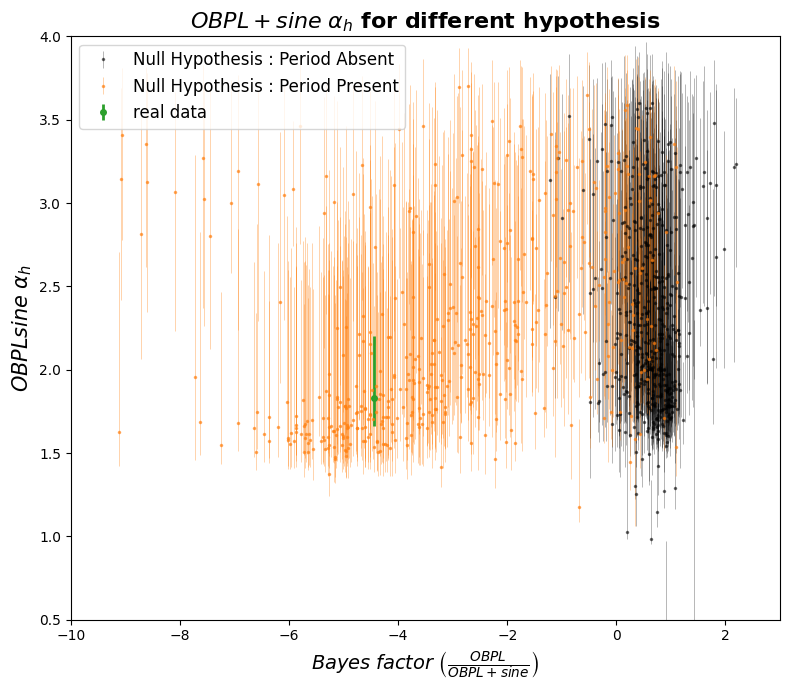

In [47]:
plt.figure(figsize = [8, 7])
plt.errorbar(np.log10(Bayes_test_nosinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_nosinehyp['OBPLsine10_alpha_h'], 
             yerr = [Bayes_test_nosinehyp['OBPLsine10_alpha_h'] - Bayes_test_nosinehyp['OBPLsine10_alpha_h_16'],
                     Bayes_test_nosinehyp['OBPLsine10_alpha_h_84'] - Bayes_test_nosinehyp['OBPLsine10_alpha_h']], 
             fmt = '.', elinewidth=0.4, ecolor = 'k', markersize = 3, markerfacecolor ='k', markeredgecolor ='k', alpha = 0.5, label = 'Null Hypothesis : Period Absent')

plt.errorbar(np.log10(Bayes_test_sinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_sinehyp['OBPLsine10_alpha_h'],
             yerr = [Bayes_test_sinehyp['OBPLsine10_alpha_h'] - Bayes_test_sinehyp['OBPLsine10_alpha_h_16'], 
                     Bayes_test_sinehyp['OBPLsine10_alpha_h_84'] - Bayes_test_sinehyp['OBPLsine10_alpha_h'] ], 
             fmt = '.', elinewidth=0.4, ecolor = 'tab:orange', markersize = 3, markerfacecolor ='tab:orange', markeredgecolor ='tab:orange', alpha = 0.6, label = 'Null Hypothesis : Period Present')

plt.errorbar(np.log10(org_OBPL10_OBPL10sine_bayes_factor), 1.83, yerr = [[0.17], [.37]], fmt = '.' ,  markersize = 8, elinewidth=2, label = 'real data')
plt.xlabel(r'$Bayes\;factor\;\left(\frac{}{}\right)$'.format("{OBPL}", "{OBPL + sine }" ), fontsize = 14)
plt.ylabel(r'$OBPLsine\;\alpha_h$', fontsize = 15)
plt.xlim(-10, 3)
plt.legend(fontsize = 12, loc = 'upper left')
plt.ylim(0.5, 4)
plt.title(r'$OBPL+sine\; \alpha_h$ for different hypothesis ', fontsize = 16, weight = 'bold')
plt.tight_layout()
#plt.plot(np.log10(Bayes_test_nosinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_nosinehyp['OBPLsine10_alpha_h'], '.')

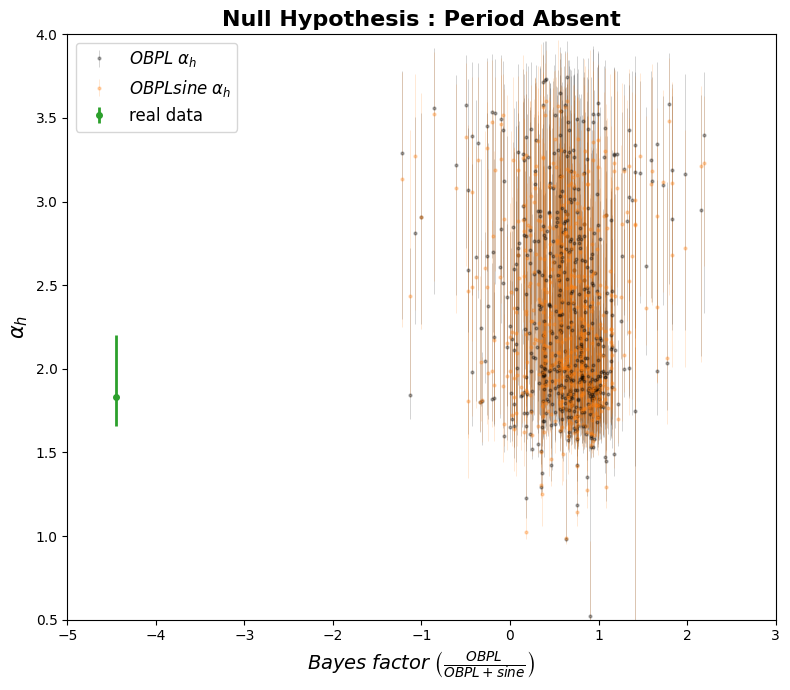

In [48]:
plt.figure(figsize = [8, 7])
plt.errorbar(np.log10(Bayes_test_nosinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_nosinehyp['OBPL10_alpha_h'], 
             yerr = [Bayes_test_nosinehyp['OBPL10_alpha_h'] - Bayes_test_nosinehyp['OBPL10_alpha_h_16'],
                     Bayes_test_nosinehyp['OBPL10_alpha_h_84'] - Bayes_test_nosinehyp['OBPL10_alpha_h']], 
             fmt = '.', elinewidth=0.4, ecolor = 'k', markersize = 4, markerfacecolor ='k', markeredgecolor ='k', alpha = 0.3, label = r'$OBPL\;\alpha_h$')

plt.errorbar(np.log10(Bayes_test_nosinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_nosinehyp['OBPLsine10_alpha_h'],
             yerr = [Bayes_test_nosinehyp['OBPLsine10_alpha_h'] - Bayes_test_nosinehyp['OBPLsine10_alpha_h_16'], 
                     Bayes_test_nosinehyp['OBPLsine10_alpha_h_84'] - Bayes_test_nosinehyp['OBPLsine10_alpha_h'] ], 
             fmt = '.', elinewidth=0.4, ecolor = 'tab:orange', markersize = 4, markerfacecolor ='tab:orange', markeredgecolor ='tab:orange', alpha = 0.3, 
             label = r'$OBPLsine\;\alpha_h$')

plt.errorbar(np.log10(org_OBPL10_OBPL10sine_bayes_factor), 1.83, yerr = [[0.17], [.37]], fmt = '.' ,  markersize = 8, elinewidth=2, label = 'real data')
plt.xlabel(r'$Bayes\;factor\;\left(\frac{}{}\right)$'.format("{OBPL}", "{OBPL + sine }" ), fontsize = 14)
plt.ylabel(r'$\alpha_h$', fontsize = 15)
plt.xlim(-5, 3)
plt.legend(fontsize = 12, loc = 'upper left')
plt.ylim(0.5, 4)
plt.title('Null Hypothesis : Period Absent', fontsize = 16, weight = 'bold')
plt.tight_layout()
#plt.plot(np.log10(Bayes_test_nosinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_nosinehyp['OBPLsine10_alpha_h'], '.')

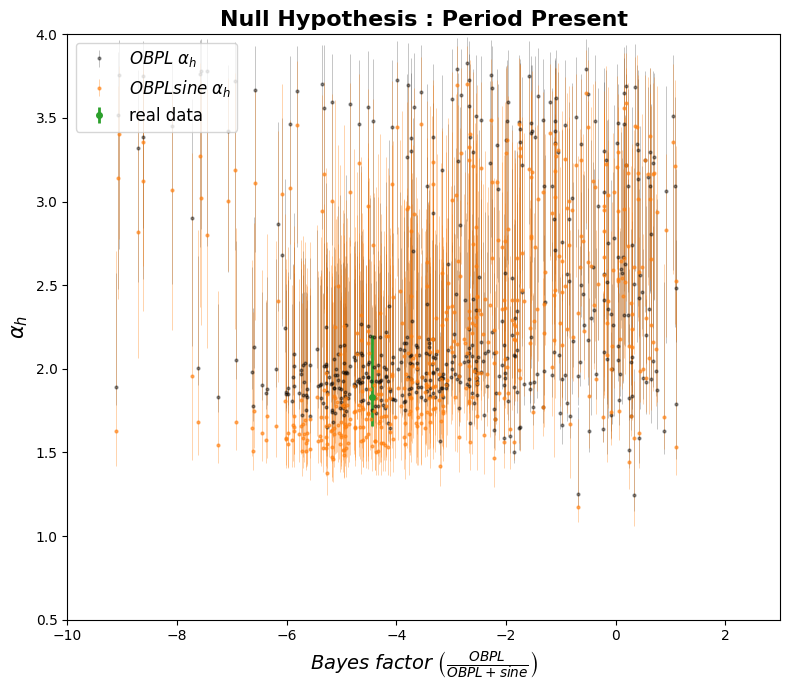

In [49]:
plt.figure(figsize = [8, 7])
plt.errorbar(np.log10(Bayes_test_sinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_sinehyp['OBPL10_alpha_h'], 
             yerr = [Bayes_test_sinehyp['OBPL10_alpha_h'] - Bayes_test_sinehyp['OBPL10_alpha_h_16'],
                     Bayes_test_sinehyp['OBPL10_alpha_h_84'] - Bayes_test_sinehyp['OBPL10_alpha_h']], 
             fmt = '.', elinewidth=0.4, ecolor = 'k', markersize = 4, markerfacecolor ='k', markeredgecolor ='k', alpha = 0.4, label = r'$OBPL\;\alpha_h$')

plt.errorbar(np.log10(Bayes_test_sinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_sinehyp['OBPLsine10_alpha_h'],
             yerr = [Bayes_test_sinehyp['OBPLsine10_alpha_h'] - Bayes_test_sinehyp['OBPLsine10_alpha_h_16'], 
                     Bayes_test_sinehyp['OBPLsine10_alpha_h_84'] - Bayes_test_sinehyp['OBPLsine10_alpha_h'] ], 
             fmt = '.', elinewidth=0.4, ecolor = 'tab:orange', markersize = 4, markerfacecolor ='tab:orange', markeredgecolor ='tab:orange', alpha = 0.6, 
             label = r'$OBPLsine\;\alpha_h$')

plt.errorbar(np.log10(org_OBPL10_OBPL10sine_bayes_factor), 1.83, yerr = [[0.17], [.37]], fmt = '.' ,  markersize = 8, elinewidth=2, label = 'real data')
plt.xlabel(r'$Bayes\;factor\;\left(\frac{}{}\right)$'.format("{OBPL}", "{OBPL + sine }" ), fontsize = 14)
plt.ylabel(r'$\alpha_h$', fontsize = 15)
plt.xlim(-10, 3)
plt.legend(fontsize = 12, loc = 'upper left')
plt.ylim(0.5, 4)
plt.title('Null Hypothesis : Period Present', fontsize = 16, weight = 'bold')
plt.tight_layout()
#plt.plot(np.log10(Bayes_test_nosinehyp['OBPL10_OBPLsine10_bayes']), Bayes_test_nosinehyp['OBPLsine10_alpha_h'], '.')

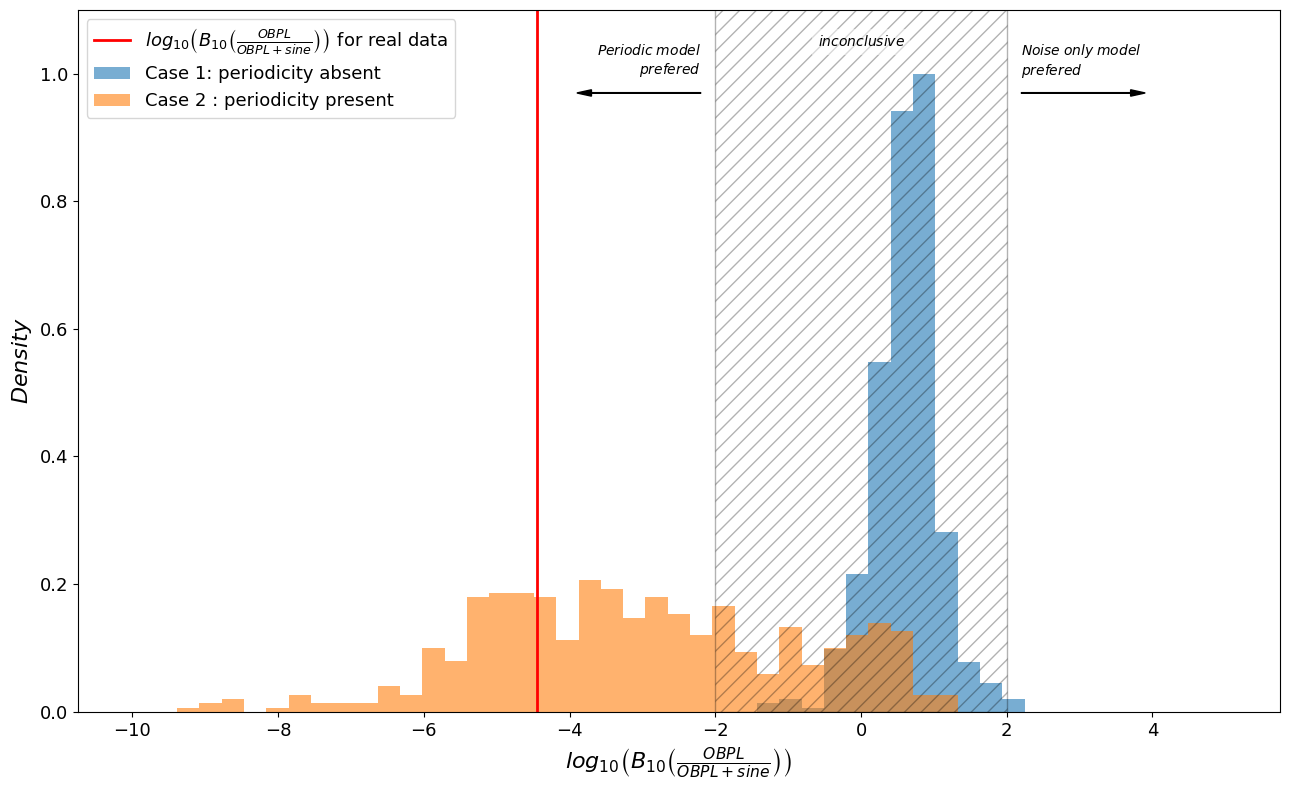

In [50]:
if True:
    # density = gaussian_kde(np.log10(test['OBPL10_OBPLsine10_bayes']))

    plt.figure(figsize=[13,8])
    # xs = np.linspace(-3,3,200)
    # density.covariance_factor = lambda : .5
    # density._compute_covariance()
    
    plt.axvline(np.log10(org_OBPL10_OBPL10sine_bayes_factor), color = 'r', lw = 2, label = r'$log_{10}\left(B_{10}\left(\frac{OBPL}{OBPL + sine}\right)\right)$ for real data',)
    #plt.axvline(np.log10(org_DRW_DRWsine_bayes_factor), color = 'b', lw = 2, label = 'DRW bayes factor')
    #plt.axvline(np.log10(org_CARMA21_CARMA21sine_bayes_factor), color = 'g', lw = 2, label = 'CARMA21 bayes factor')

    #plt.plot(xs,density(xs), 'k--', label = 'Gaussian KDE')
    counts1 = plt.hist(np.log10(Bayes_test_nosinehyp['OBPL10_OBPLsine10_bayes']), bins = np.linspace(-10, 5, 50), density=True, label = 'Case 1: periodicity absent', alpha = 0.6)
    counts2 = plt.hist(np.log10(Bayes_test_sinehyp['OBPL10_OBPLsine10_bayes']), bins = np.linspace(-10, 5, 50), density=True, label = 'Case 2 : periodicity present', alpha = 0.6)

#     line_styles = [plt.Line2D([0], [0], color='k', linestyle='-'),
#                 plt.Line2D([0], [0], color='k', linestyle='--')]
#     line_style_labels = ['orginal data', 'sim data :  gaussian kde']
#     colors = [plt.Line2D([0], [0], color='r', lw=4),
#             plt.Line2D([0], [0], color='b', lw=4),
#             plt.Line2D([0], [0], color='g', lw=4)]
#     color_labels = ['OBPL bayes factor', 'DRW bayes factor', 'CARMA21 bayes factor' ]

#     legend1 = plt.legend(line_styles, line_style_labels, loc='upper left', bbox_to_anchor=(0.005, 0.99))
#     legend2 = plt.legend(colors, color_labels, loc='upper left', bbox_to_anchor=(0.005, 0.86))

    # Add the first legend back to the plot
    plt.legend(loc = 'upper left', fontsize = 13)
    arrow_style = {
        "head_width": 0.01,
        "head_length": 0.2,
        "color":"k"
    }    
    plt.fill_betweenx(np.linspace(0, max(max(counts1[0]), max(counts2[0]))+1, 10), -2, 2, hatch = '//', facecolor ="none", alpha = 0.3)
    plt.text(0, max(max(counts1[0]), max(counts2[0]))+0.05, '$inconclusive$', fontsize = 10, horizontalalignment = 'center', verticalalignment = 'center',
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    
    plt.text(-2.2, max(max(counts1[0]), max(counts2[0]))+0.02, '$Periodic\; model$\n$prefered$',horizontalalignment = 'right', verticalalignment = 'center', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(-2.2, max(max(counts1[0]), max(counts2[0]))-0.03, -1.5, 0, **arrow_style)
    
    plt.text(2.2, max(max(counts1[0]), max(counts2[0]))+0.02, '$Noise\;only\; model$\n$prefered$',horizontalalignment = 'left', verticalalignment = 'center', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(2.2, max(max(counts1[0]), max(counts2[0]))-0.03, +1.5, 0, **arrow_style)
    
    plt.ylim(0, max(max(counts1[0]), max(counts2[0]))+0.1)
    plt.ylabel(r'$Density$', fontsize = 16)
    plt.xlabel(r'$log_{}\left(B_{}\left(\frac{}{}\right)\right)$'.format("{10}","{10}","{OBPL}", "{OBPL + sine }" ), fontsize =16)
    plt.tick_params(labelsize = 13)
    plt.tight_layout()
    plt.show()

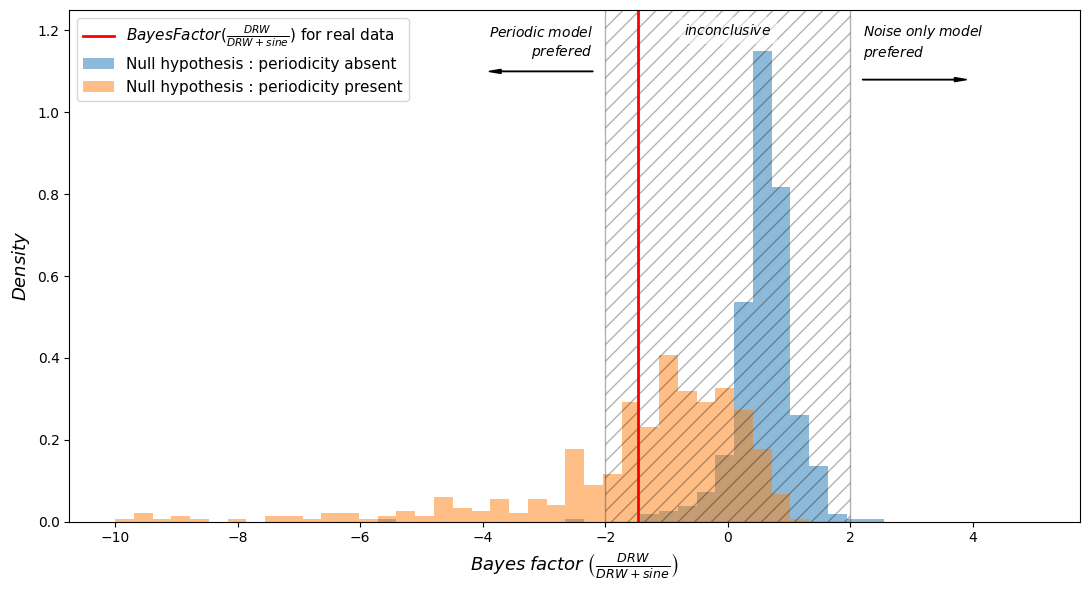

In [51]:
if True:
    # density = gaussian_kde(np.log10(test['OBPL10_OBPLsine10_bayes']))

    plt.figure(figsize=[11,6])
    # xs = np.linspace(-3,3,200)
    # density.covariance_factor = lambda : .5
    # density._compute_covariance()
    
    
    plt.axvline(np.log10(org_DRW_DRWsine_bayes_factor), color = 'r', lw = 2, label = r'$BayesFactor(\frac{DRW}{DRW + sine})$ for real data')
    #plt.axvline(np.log10(org_DRW_DRWsine_bayes_factor), color = 'b', lw = 2, label = 'DRW bayes factor')
    #plt.axvline(np.log10(org_CARMA21_CARMA21sine_bayes_factor), color = 'g', lw = 2, label = 'CARMA21 bayes factor')

    #plt.plot(xs,density(xs), 'k--', label = 'Gaussian KDE')
    counts1 = plt.hist(np.log10(Bayes_test_nosinehyp['DRW_DRWsine_bayes']), bins = np.linspace(-10, 5, 50), density=True, label = 'Null hypothesis : periodicity absent', alpha = 0.5)
    counts2 = plt.hist(np.log10(Bayes_test_sinehyp['DRW_DRWsine_bayes']), bins = np.linspace(-10, 5, 50), density=True, label = 'Null hypothesis : periodicity present', alpha = 0.5)
#     line_styles = [plt.Line2D([0], [0], color='k', linestyle='-'),
#                 plt.Line2D([0], [0], color='k', linestyle='--')]
#     line_style_labels = ['orginal data', 'sim data :  gaussian kde']
#     colors = [plt.Line2D([0], [0], color='r', lw=4),
#             plt.Line2D([0], [0], color='b', lw=4),
#             plt.Line2D([0], [0], color='g', lw=4)]
#     color_labels = ['OBPL bayes factor', 'DRW bayes factor', 'CARMA21 bayes factor' ]

#     legend1 = plt.legend(line_styles, line_style_labels, loc='upper left', bbox_to_anchor=(0.005, 0.99))
#     legend2 = plt.legend(colors, color_labels, loc='upper left', bbox_to_anchor=(0.005, 0.86))

    # Add the first legend back to the plot
    plt.legend(loc = 'upper left', fontsize = 11)
    arrow_style = {
        "head_width": 0.01,
        "head_length": 0.2,
        "color":"k"
    }    
    
    plt.fill_betweenx(np.linspace(0, max(max(counts1[0]), max(counts2[0]))+1, 10), -2, 2, hatch = '//', facecolor ="none", alpha = 0.3)
    plt.text(0, max(max(counts1[0]), max(counts2[0]))+0.05, '$inconclusive$', fontsize = 10, horizontalalignment = 'center', verticalalignment = 'center',
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    
    plt.text(-2.2, max(max(counts1[0]), max(counts2[0]))+0.02, '$Periodic\; model$\n$prefered$',horizontalalignment = 'right', verticalalignment = 'center', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(-2.2, max(max(counts1[0]), max(counts2[0]))-0.05, -1.5, 0, **arrow_style)
    
    plt.text(2.2, max(max(counts1[0]), max(counts2[0]))+0.02, '$Noise\;only\; model$\n$prefered$',horizontalalignment = 'left', verticalalignment = 'center', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(2.2, max(max(counts1[0]), max(counts2[0]))-0.07, +1.5, 0, **arrow_style)
    
    plt.ylim(0, max(max(counts1[0]), max(counts2[0]))+0.1)
    plt.ylabel(r'$Density$', fontsize = 13)
    plt.xlabel(r'$Bayes\;factor\;\left(\frac{}{}\right)$'.format("{DRW}", "{DRW + sine }" ), fontsize =13)
    plt.tight_layout()
    plt.show()

In [52]:
if False:
    # density = gaussian_kde(np.log10(test['OBPL10_OBPLsine10_bayes']))

    plt.figure(figsize=[11,6])
    # xs = np.linspace(-3,3,200)
    # density.covariance_factor = lambda : .5
    # density._compute_covariance()
    
    plt.axvline(np.log10(org_DRW_DRWsine_bayes_factor), color = 'r', lw = 2, label = r'$BayesFactor(\frac{CARMA(2,1)}{CARMA(2,1) + sine})$ for real data')
    #plt.axvline(np.log10(org_DRW_DRWsine_bayes_factor), color = 'b', lw = 2, label = 'DRW bayes factor')
    #plt.axvline(np.log10(org_CARMA21_CARMA21sine_bayes_factor), color = 'g', lw = 2, label = 'CARMA21 bayes factor')

    #plt.plot(xs,density(xs), 'k--', label = 'Gaussian KDE')
    counts1 = plt.hist(np.log10(Bayes_test_nosinehyp['CARMA21_CARMA21sine_bayes']), bins = np.linspace(-10, 5, 50), density=True,label = 'Null hypothesis : periodicity absent', alpha = 0.5)
    counts2 = plt.hist(np.log10(Bayes_test_sinehyp['CARMA21_CARMA21sine_bayes']), bins = np.linspace(-10, 5, 50), density=True, label = 'Null hypothesis : periodicity present', alpha = 0.5)

#     line_styles = [plt.Line2D([0], [0], color='k', linestyle='-'),
#                 plt.Line2D([0], [0], color='k', linestyle='--')]
#     line_style_labels = ['orginal data', 'sim data :  gaussian kde']
#     colors = [plt.Line2D([0], [0], color='r', lw=4),
#             plt.Line2D([0], [0], color='b', lw=4),
#             plt.Line2D([0], [0], color='g', lw=4)]
#     color_labels = ['OBPL bayes factor', 'DRW bayes factor', 'CARMA21 bayes factor' ]

#     legend1 = plt.legend(line_styles, line_style_labels, loc='upper left', bbox_to_anchor=(0.005, 0.99))
#     legend2 = plt.legend(colors, color_labels, loc='upper left', bbox_to_anchor=(0.005, 0.86))

    # Add the first legend back to the plot
    plt.legend(loc = 'upper left', fontsize = 11)
    arrow_style = {
        "head_width": 0.01,
        "head_length": 0.2,
        "color":"k"
    }    
    plt.fill_betweenx(np.linspace(0, max(max(counts1[0]), max(counts2[0]))+1, 10), -2, 2, hatch = '//', facecolor ="none", alpha = 0.3)

    plt.text(0, max(max(counts1[0]), max(counts2[0]))+0.07, '$inconclusive$', fontsize = 10, horizontalalignment = 'center', verticalalignment = 'top',
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    
    plt.text(-2.2, max(max(counts1[0]), max(counts2[0]))+0.07, '$Periodic\; model$\n$prefered$',horizontalalignment = 'right', verticalalignment = 'top', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(-2.2, max(max(counts1[0]), max(counts2[0]))-0.04, -1.5, 0, **arrow_style)
    
    plt.text(2.2, max(max(counts1[0]), max(counts2[0]))+0.07, '$Noise\;only\; model$\n$prefered$',horizontalalignment = 'left', verticalalignment = 'top', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(2.2, max(max(counts1[0]), max(counts2[0]))-0.04, +1.5, 0, **arrow_style)
    
    plt.ylim(0, max(max(counts1[0]), max(counts2[0]))+0.1)
    plt.ylabel(r'$Density$', fontsize = 13)
    plt.xlabel(r'$Bayes\;factor\;\left(\frac{}{}\right)$'.format("{CARMA21}", "{CARMA(2,1) + sine }" ), fontsize =13)
    plt.tight_layout()
    plt.show()

# FERMI PG1553_113


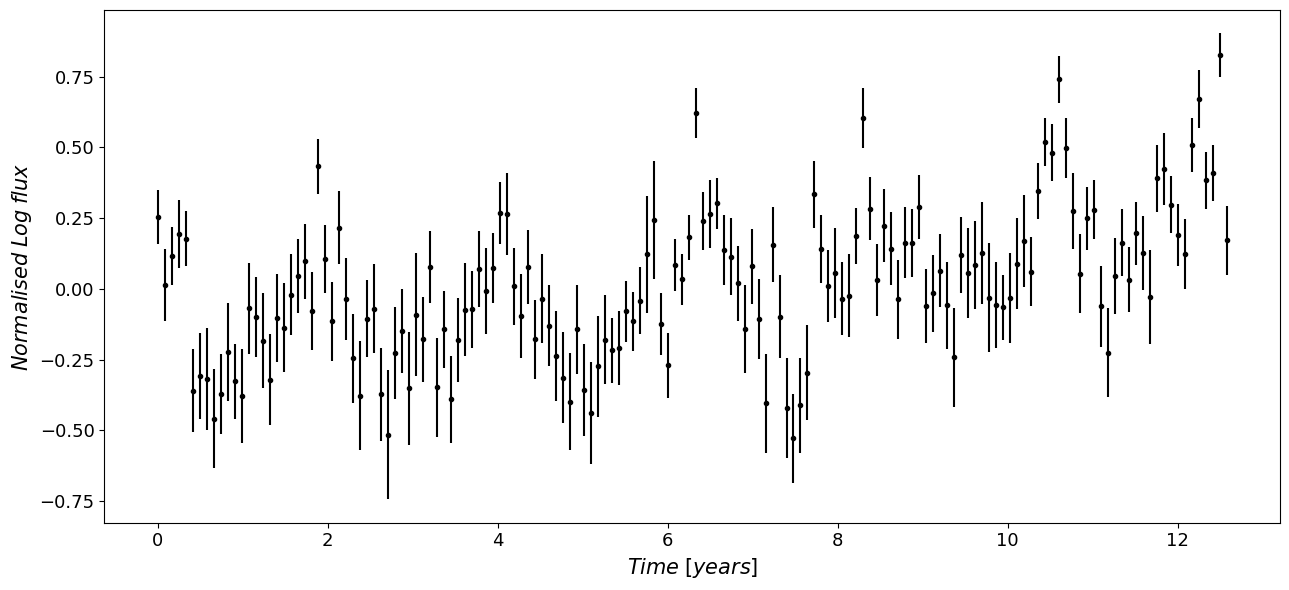

In [53]:

lcTIME, lcFLUX, lcFLUXerr = np.loadtxt('AGNobsdata/PG1553_113_logbase.txt').T

lcFLUX = lcFLUX - np.median(lcFLUX)
plt.figure(figsize=[13, 6])
plt.errorbar(lcTIME, lcFLUX, yerr=lcFLUXerr, fmt = '.', color = 'k')
plt.xlabel('$Time\;[years]$', fontsize = 15)
plt.ylabel('$Normalised\;Log\;flux$', fontsize = 15)
plt.tick_params(labelsize = 13)
plt.tight_layout()

In [55]:
org_DRW_dict = load_json('real_data_tests/final/PG1553_113_logbase/original_data_DRW.json')
org_DRWsine_dict = load_json('real_data_tests/final/PG1553_113_logbase/original_data_DRWsine.json')

org_DRW_linear_dict = load_json('real_data_tests/final/PG1553_113_logbase/original_data_DRW_linear.json')
org_DRWsine_linear_dict = load_json('real_data_tests/final/PG1553_113_logbase/original_data_DRWsine_linear.json')

# org_CARMA21_dict = load_json('real_data_tests/PG1553_113_logbase/original_data_CARMA21.json')
# org_CARMA21sine_dict = load_json('real_data_tests/PG1553_113_logbase/original_data_CARMA21sine.json')


org_OBPL10_dict = load_json('real_data_tests/final/PG1553_113_logbase/original_data_OBPL10.json')
org_OBPL10sine_dict = load_json('real_data_tests/final/PG1553_113_logbase/original_data_OBPL10sine.json')


org_OBPL10_linear_dict = load_json('real_data_tests/final/PG1553_113_logbase/original_data_OBPL10_linear.json')
org_OBPL10sine_linear_dict = load_json('real_data_tests/final/PG1553_113_logbase/original_data_OBPL10sine_linear.json')

In [56]:
print(org_OBPL10_dict['log_Z_mean'], org_OBPL10sine_dict['log_Z_mean'], org_OBPL10_linear_dict['log_Z_mean'], org_OBPL10sine_linear_dict['log_Z_mean'])
print( org_DRW_dict['log_Z_mean'], org_DRWsine_dict['log_Z_mean'], org_DRW_linear_dict['log_Z_mean'], org_DRWsine_linear_dict['log_Z_mean'], )

26.291384088035713 29.864327840634814 20.482980917210348 24.94094015427104
17.39791846314675 20.769915665861237 12.764386719438344 15.924613431180754


In [57]:
print( np.log10(np.exp(org_DRW_dict['log_Z_mean'] - org_DRWsine_dict['log_Z_mean'])) ) 
print( np.log10(np.exp(org_DRW_linear_dict['log_Z_mean'] - org_DRWsine_linear_dict['log_Z_mean'])) ) 
print( np.log10(np.exp(org_OBPL10_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])) ) 
print( np.log10(np.exp(org_OBPL10_linear_dict['log_Z_mean'] - org_OBPL10sine_linear_dict['log_Z_mean'])) ) 
print( np.log10(np.exp(org_DRWsine_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])) )
print( np.log10(np.exp(org_OBPL10sine_linear_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])) )

print('\n')
print( 10**np.log10(np.exp(org_DRW_dict['log_Z_mean'] - org_DRWsine_dict['log_Z_mean'])) ) 
print( 10**np.log10(np.exp(org_OBPL10_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])) ) 
print( 10**np.log10(np.exp(org_DRW_linear_dict['log_Z_mean'] - org_DRWsine_linear_dict['log_Z_mean'])) ) 
print( 10**np.log10(np.exp(org_OBPL10_linear_dict['log_Z_mean'] - org_OBPL10sine_linear_dict['log_Z_mean'])) ) 
print( 10**np.log10(np.exp(org_DRWsine_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])) )


-1.4644397781321035
-1.3724690224729874
-1.5517097559044872
-1.9360670972050888
-3.9496530236579166
-2.138200104458205


0.034321022807796066
0.02807309168802945
0.042416123757049236
0.011585983423307753
0.00011229152407829855


In [58]:


def plot_corner(dictionary: dict, log_scale_keys: list = None, exclude_keys: list = ['log_Z_mean', 'log_Z_uncert']):
    """
    Create a corner plot from a dictionary of data arrays.

    Parameters:
    - dictionary (dict): Dictionary containing data arrays to plot.
    - log_scale_keys (list): Keys of the dictionary to apply log scale. Defaults to None.
    - exclude_keys (list): Keys to exclude from the plot. Defaults to ['log_Z_mean', 'log_Z_uncert'].

    Returns:
    - fig: The figure object containing the corner plot.
    - axes: The axes object for the subplots.
    """
    if exclude_keys is None:
        exclude_keys = []
    if log_scale_keys is None:
        log_scale_keys = []

    # Define the key renaming mapping
    key_mapping = {
        'A1': '$A_1$',
        'A2': '$A_2$',
        't0': '$T_{period}$',
        'log_bend_freq': '$log_{10}(f_{bend})$',
        'log_amp': '$log_{10}(A)$',
        'err_scale': '$\\nu$',
        'alpha_l' : '$\\alpha_l$',
        'alpha_h' : '$\\alpha_h$'
    }

    # Filter the dictionary
    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    # # Transform specified keys to log scale
    # for key in log_scale_keys:
    #     if key in filtered_data:
    #         filtered_data[key] = np.log10(filtered_data[key])
    #         filtered_data[key] = np.where(filtered_data[key] == -np.inf, np.nan, filtered_data[key])  # Handle -inf values

    # Rename keys based on the mapping
    renamed_data = {key_mapping.get(key, key): value for key, value in filtered_data.items()}

    # Prepare the data for plotting
    data = np.array([array for array in renamed_data.values()]).T

    # Create the corner plot
    fig = corner.corner(data, bins=50, labels=list(renamed_data.keys()), show_titles=True, title_kwargs={"fontsize": 14}, label_kwargs={'fontsize':18})

    # Accessing each subplot individually
    axes = np.array(fig.axes).reshape((len(renamed_data), len(renamed_data)))

     # Calculate modes for each subplot
    modes = {}
    num_params = len(renamed_data)

    for i in range(num_params):
        for j in range(num_params):
            if i == j:
                # Diagonal subplots: mode of the histogram for the single parameter
                key = list(renamed_data.keys())[i]
                hist, bins = np.histogram(renamed_data[key], bins=50)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                peak_value = bin_centers[np.argmax(hist)]
                modes[(i, j)] = (peak_value, peak_value)  # Mode is the same for both x and y
            else:
                # Off-diagonal subplots: mode of the histogram for x and y directions
                x_peak = mode(data[:, j], nan_policy='omit').mode
                y_peak = mode(data[:, i], nan_policy='omit').mode
                modes[(i, j)] = (x_peak, y_peak)

            


    # Customize the plot to reflect log scaling in labels
    def log_formatter(val, pos):
        return r"$10^{{{:.0f}}}$".format(val)
    for i, key in enumerate(renamed_data.keys()):
        if key in [key_mapping.get(k, k) for k in log_scale_keys]:  # Check if renamed key is in log_scale_keys
            for j in range(len(renamed_data)):
                if i == j:
                    ax = axes[i, j]
                    #ax.set_title(f"log10({key})", fontsize=12)
                    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))
                    ax.yaxis.set_major_formatter(FuncFormatter(log_formatter))
                    axes[-1, j].set_xlabel(f"{key}", fontsize=18)
                    axes[-1, j].xaxis.set_major_formatter(FuncFormatter(log_formatter))
                    axes[i, 0].set_ylabel(f"{key}", fontsize=18)
                    axes[i, 0].yaxis.set_major_formatter(FuncFormatter(log_formatter))
                    
                    # Calculate and display percentiles
                    percentiles = np.percentile(renamed_data[key], [16, 50, 84])
                    if key == '$log_{10}(f_{bend})$':
                        ax.set_title(f"{key}$={percentiles[1]:.2f}^{{+{percentiles[2]-percentiles[1]:.2f}}}_{{-{percentiles[1]-percentiles[0]:.2f}}}$", fontsize=12.5)    
                    else:
                        ax.set_title(f"{key}$={percentiles[1]:.2f}^{{+{percentiles[2]-percentiles[1]:.2f}}}_{{-{percentiles[1]-percentiles[0]:.2f}}}$", fontsize=14)

    # for i in range(num_params):
    #     for j in range(num_params):
    #         if i>j:
    #             ax = axes[i, j]
    #             ax.axvline(modes[(i, j)][0])   
    #             ax.axhline(modes[(i, j)][1])           
    
    plt.show()
    return fig, axes


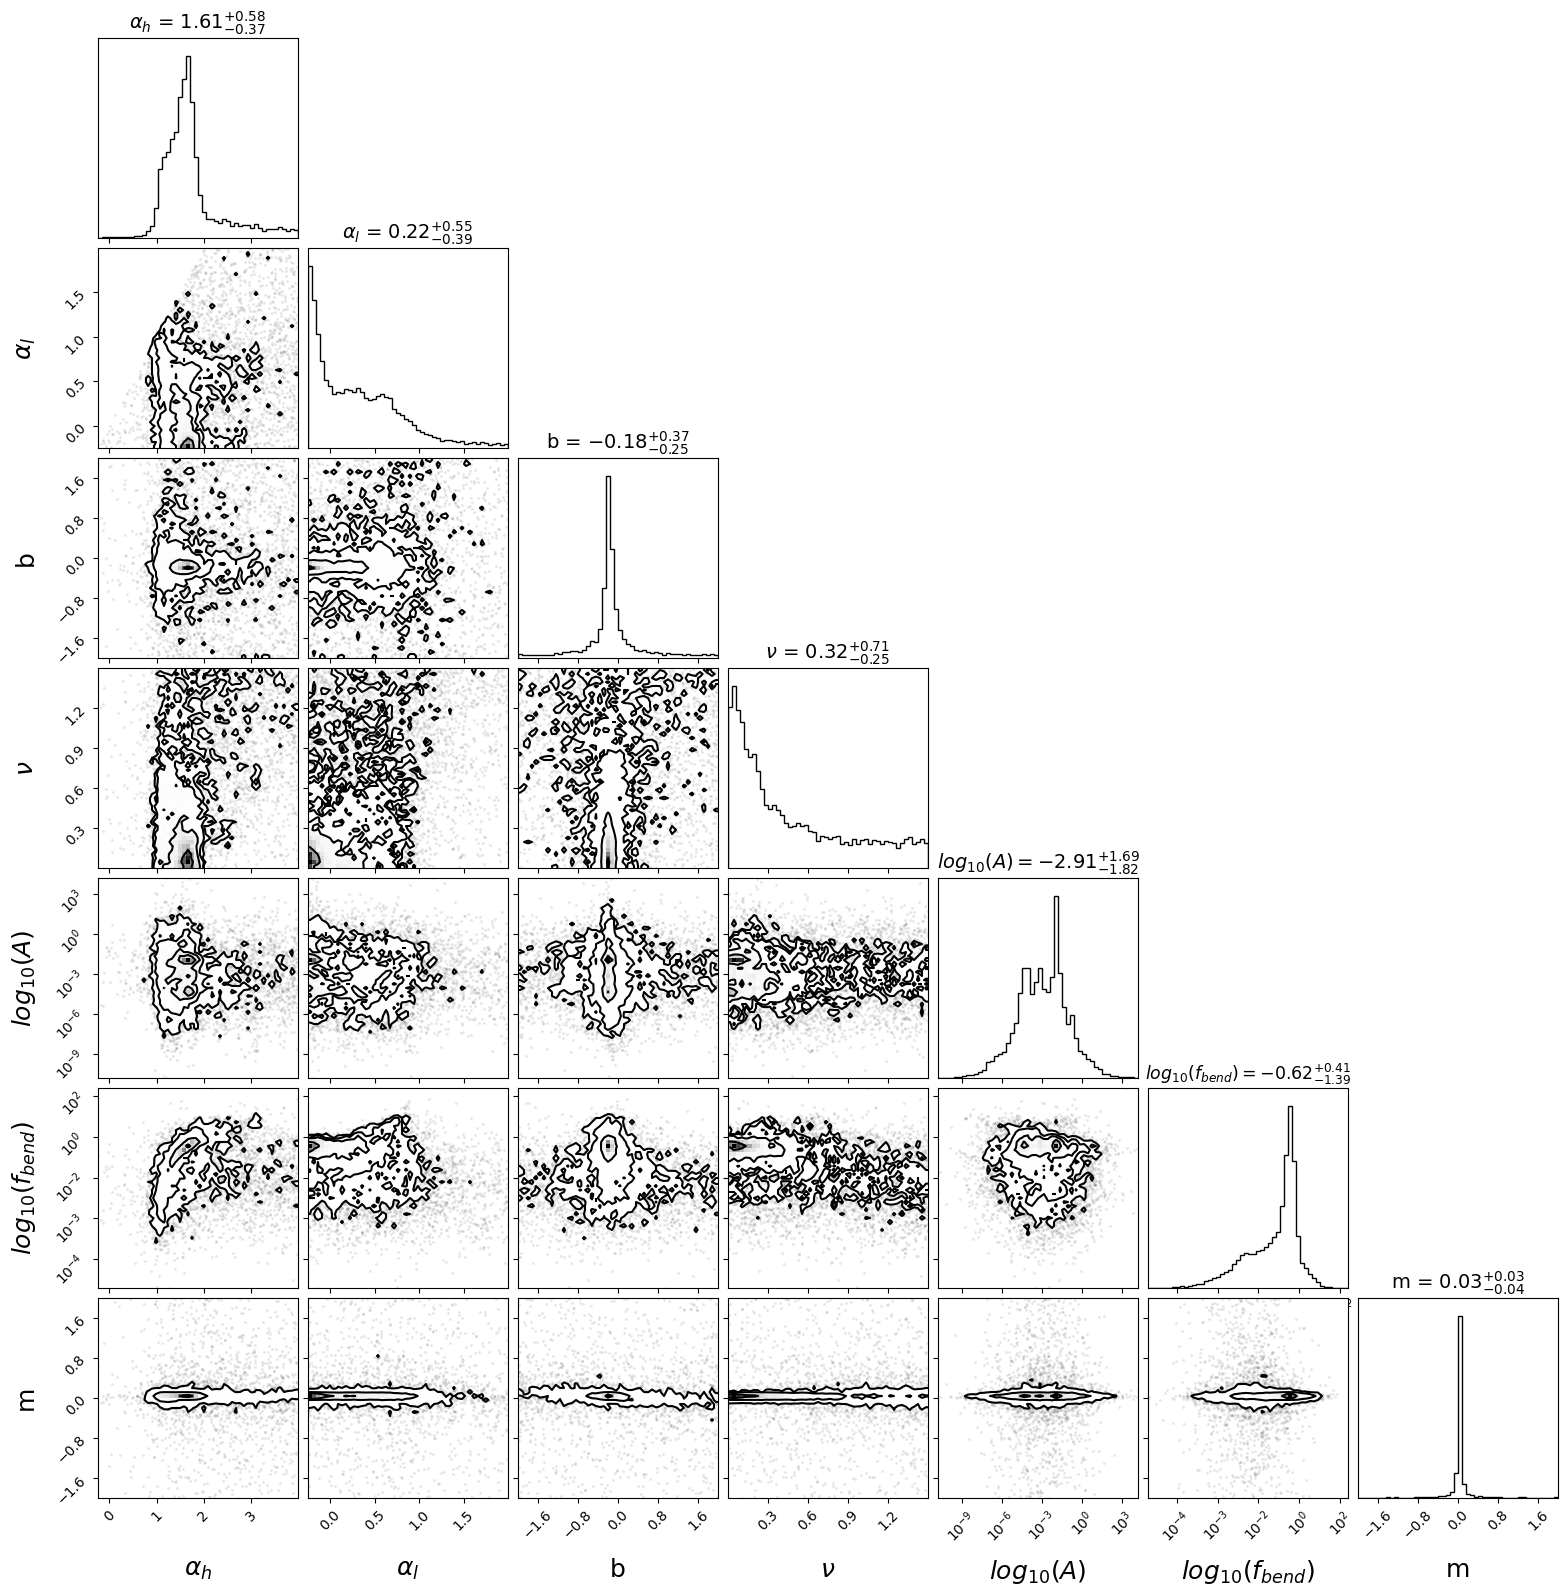

In [59]:
_ = plot_corner(org_OBPL10_linear_dict, log_scale_keys=['log_amp', 'log_bend_freq'], exclude_keys=['log_Z_mean', 'log_Z_uncert'])

In [60]:
def sine_curve_model(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 

def sine_linear_model(params, time):
    
    return sine_curve_model(params, time) + params['m']*time + params['b']

def linear_model(params, time):
    
    return params['m']*time + params['b']
    

def sample_posterior_within_1sigma(param_samples_dict, num_samples, q = [0, 100]):
    param_names = list(param_samples_dict.keys())
    param_samples = np.array(list(param_samples_dict.values()))
    lower_quantiles, upper_quantiles = np.percentile(param_samples, q, axis=1)
    
    within_1sigma_mask = np.all((param_samples.T >= lower_quantiles) & (param_samples.T <= upper_quantiles), axis=1)
    filtered_samples = param_samples[:, within_1sigma_mask].T
    
    if len(filtered_samples) < num_samples:
        raise ValueError("Not enough samples within 1σ to draw the desired number of samples")
    
    sampled_indices = np.random.choice(filtered_samples.shape[0], size=num_samples, replace=False)
    sampled_params = filtered_samples[sampled_indices]
    
    if num_samples==1:
        sampled_values_dict = {param_names[i]: sampled_params[:, i][0] for i in range(len(param_names))}
    else:
        sampled_values_dict = {param_names[i]: sampled_params[:, i] for i in range(len(param_names))}
    
    return sampled_values_dict

def build_gp_DRW(theta, X, diag, mean_val = 0):

    log_amp = theta["log_amp"]
    log_bend_freq= theta["log_bend_freq"]
    err_scale = theta['err_scale']

    kernel = np.power(10, log_amp) * kernels.Exp(scale = 1/(np.power(10, log_bend_freq)))
    
    return GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean= mean_val)


def build_gp_OBPL(theta, X, y, diag, mean_val = 0):

    log_amp = theta["log_amp"]
    alpha_l = theta["alpha_l"]
    alpha_h = theta["alpha_h"]
    log_bend_freq= theta["log_bend_freq"]
    err_scale = theta['err_scale']

    psd = OneBendPowerLaw([np.power(10, log_amp), alpha_l, np.power(10, log_bend_freq), alpha_h], free_parameters=[True]*4)
    
    model_ACV = PSDToACV(psd, S_low=100,
                S_high=20,
                T=X[-1] - X[0],
                dt=np.min(np.diff(X)),
                method='SHO',
                n_components=10,
                estimate_variance=True,
                init_variance=jnp.var(y, ddof=1),
                use_celerite=False,
                use_legacy_celerite=False )
    
    kernel = model_ACV.ACVF

    return GaussianProcess(kernel, X, diag=(diag*err_scale)**2, mean=mean_val)

def build_gp_CARMA21(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha0 = theta["log_alpha0"]
    log_alpha1 = theta["log_alpha1"]
    log_beta1 = theta["log_beta1"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1)])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp

def GPmaker(model, dicti, X, Y,  Yerr, mean=0):
    if 'DRW' in model:
        return build_gp_DRW(dicti, X, Yerr, mean_val=mean)
    elif 'CARMA' in model:
        return build_gp_CARMA21(dicti, X, Yerr, mean_val=mean)
    elif 'OBPL' in model:
        return build_gp_OBPL(dicti, X, Y, Yerr, mean_val=mean)
    
def meanval(model, dicti):
    if 'sine_linear' in model:
        return partial(sine_linear_model, dicti)
    elif 'sine' in model:
        return partial(sine_curve_model, dicti)
    elif 'linear' in model :
        return partial(linear_model, dicti)
    else:
         return 0

def LC_GP_plotter(model_dictiii, time, flux, flux_err, plot_samples=True, plot_what='all', fig_size =[10, 6] ):
    
    model_dict = model_dictiii.copy()
    model_dict.pop('log_Z_mean')
    model_dict.pop('log_Z_uncert')
    
    params = {}
    params_1sigma_lower = {}
    params_1sigma_upper = {}
    for (key, val) in model_dict.items():
        params[key], params_1sigma_lower[key], params_1sigma_upper[key] = np.percentile(val, [50, 16, 84])
         
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    print(params)
    
    
    x = np.linspace(min(time)-1, max(time)+1, 1000)
    
    if plot_samples:
        print(1)
        for i in tqdm(range(5), desc='Plotting samples from posteriors... '):
            sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
            # params_sample = {}
            # for (key, val) in sample_dict.items():
            #     params_sample[key] = np.percentile(val, [50])
                
            gp = GPmaker(plot_what, sample_dict, time, flux, flux_err, mean=meanval(plot_what, sample_dict))
            cond_gp = gp.condition(flux, x).gp
            mu, var = cond_gp.loc, cond_gp.variance
            if i ==0:
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(np.random.randint(0, 1000))), "b-", lw=1, alpha=0.3, label = 'samples from posterior')
            else:
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(np.random.randint(0, 1000))), "b-", lw=1, alpha=0.3,)
    
    if True:
        if 'sine_linear' in plot_what:
            for i in range(50):
                if i ==0:
                    ax.plot(x, sine_linear_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16,84]), x), 'r-', alpha = 0.2, label = 'Sine+Linear : 1$\sigma$ samples')
                else:
                    ax.plot(x, sine_linear_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16,84]), x), 'r-', alpha = 0.2)
        
        elif 'linear' in plot_what:
            for i in range(50):
                if i ==0:
                    ax.plot(x, linear_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[20,70]), x), 'r-', alpha = 0.2, label = 'Linear : 1$\sigma$ samples')
                else:
                    ax.plot(x, linear_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[20,70]), x), 'r-', alpha = 0.2)
        
        elif 'sine' in plot_what:
            for i in range(50):
                if i ==0:
                    ax.plot(x, sine_curve_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16,84]), x), 'r-', alpha = 0.2, label = 'Sine : 1 $\sigma$ samples')
                else:
                    ax.plot(x, sine_curve_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16,84]), x), 'r-', alpha = 0.2)
    
    gp = GPmaker(plot_what, params, time, flux, flux_err, mean=meanval(plot_what, params))
    cond_gp = gp.condition(flux, x).gp
    mu, var = cond_gp.loc, cond_gp.variance
    ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
    ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="y", alpha=0.7, label = r'$1\sigma\;err$')
    
    plt.xlim(min(x), max(x))
    plt.ylim(min(flux) - np.std(flux)*2, max(flux) + np.std(flux)*2)
    plt.legend(fontsize = 13, loc = 'upper left')
    plt.grid()
    plt.ylabel(r'$Normalised\;Log\;Flux$', fontsize = 16)
    plt.xlabel(r'$Time\;[years]$', fontsize = 16)
    plt.tick_params(labelsize = 12)
    plt.tight_layout()

    plt.show()


{'A1': 0.14396630887809206, 'A2': -0.08349155554456883, 'alpha_h': 1.1671611272368745, 'alpha_l': 0.6919741433465247, 'b': -0.15165198188491402, 'err_scale': 0.30344806535201263, 'log_amp': -3.4442533084753144, 'log_bend_freq': -1.3530158326624397, 'm': 0.03170823740971196, 't0': 2.1493905187128206}
1


Plotting samples from posteriors... : 100%|██████████| 5/5 [01:02<00:00, 12.51s/it]


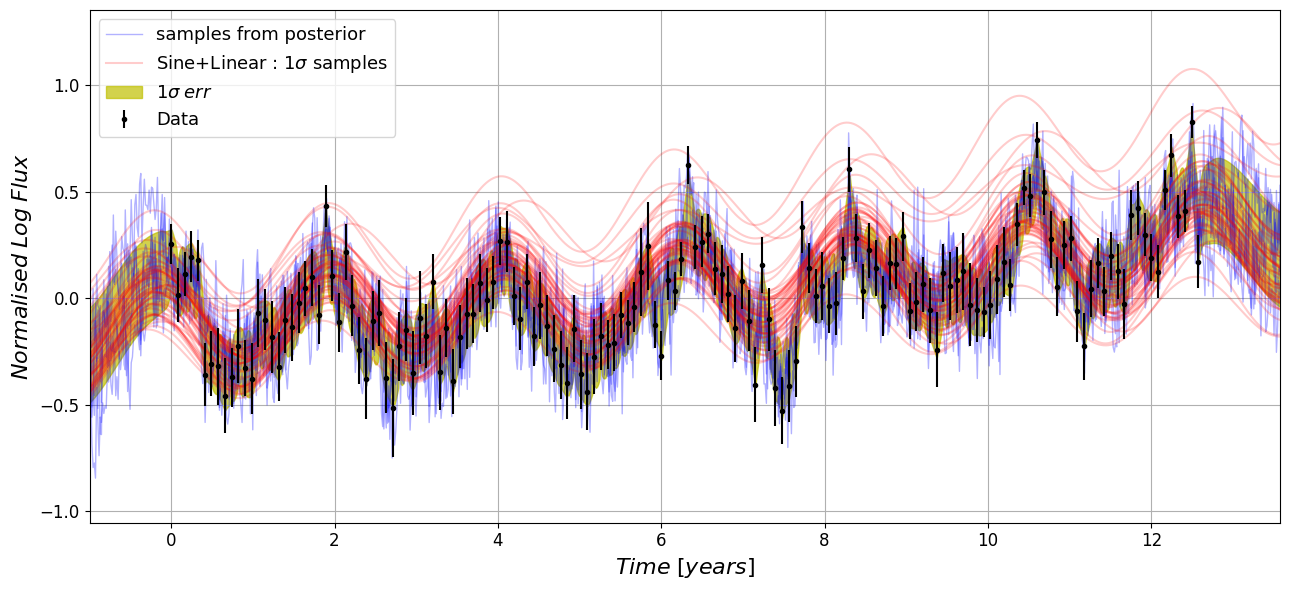

In [ ]:
LC_GP_plotter(org_OBPL10sine_linear_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='OBPLsine', fig_size=[13, 6])

In [63]:
Bayes_test_nosinehyp = datacollector_realtest(json_files_path='real_data_tests/final/PG1553_113_logbase/noperiod/')
Bayes_test_sinehyp = datacollector_realtest(json_files_path='real_data_tests/final/PG1553_113_logbase/period/')

500 500 500 500
Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 500/500 [00:11<00:00, 44.47it/s]


400 400 400 400
Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 400/400 [00:09<00:00, 42.45it/s]


In [64]:
org_OBPL10_OBPL10sine_bayes_factor = np.exp(org_OBPL10_dict['log_Z_mean'] - org_OBPL10sine_dict['log_Z_mean'])
org_DRW_DRWsine_bayes_factor = np.exp(org_DRW_dict['log_Z_mean'] - org_DRWsine_dict['log_Z_mean'])
# org_CARMA21_CARMA21sine_bayes_factor = np.exp(org_CARMA21_dict['log_Z_mean'] - org_CARMA21sine_dict['log_Z_mean'])

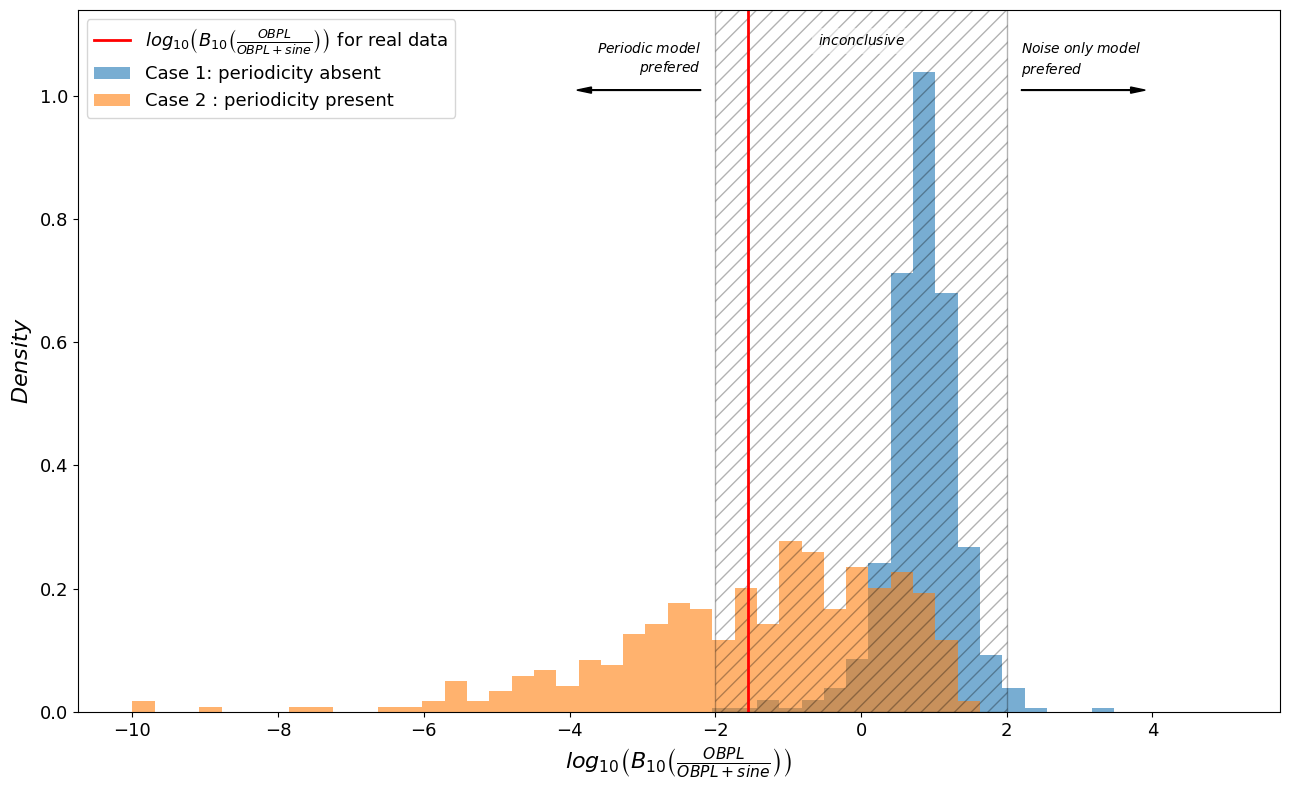

In [65]:
if True:
    # density = gaussian_kde(np.log10(test['OBPL10_OBPLsine10_bayes']))

    plt.figure(figsize=[13,8])
    # xs = np.linspace(-3,3,200)
    # density.covariance_factor = lambda : .5
    # density._compute_covariance()
    
    plt.axvline(np.log10(org_OBPL10_OBPL10sine_bayes_factor), color = 'r', lw = 2, label = r'$log_{10}\left(B_{10}\left(\frac{OBPL}{OBPL + sine}\right)\right)$ for real data',)
    #plt.axvline(np.log10(org_DRW_DRWsine_bayes_factor), color = 'b', lw = 2, label = 'DRW bayes factor')
    #plt.axvline(np.log10(org_CARMA21_CARMA21sine_bayes_factor), color = 'g', lw = 2, label = 'CARMA21 bayes factor')

    #plt.plot(xs,density(xs), 'k--', label = 'Gaussian KDE')
    counts1 = plt.hist(np.log10(Bayes_test_nosinehyp['OBPL10_OBPLsine10_bayes']), bins = np.linspace(-10, 5, 50), density=True, label = 'Case 1: periodicity absent', alpha = 0.6)
    counts2 = plt.hist(np.log10(Bayes_test_sinehyp['OBPL10_OBPLsine10_bayes']), bins = np.linspace(-10, 5, 50), density=True, label = 'Case 2 : periodicity present', alpha = 0.6)

#     line_styles = [plt.Line2D([0], [0], color='k', linestyle='-'),
#                 plt.Line2D([0], [0], color='k', linestyle='--')]
#     line_style_labels = ['orginal data', 'sim data :  gaussian kde']
#     colors = [plt.Line2D([0], [0], color='r', lw=4),
#             plt.Line2D([0], [0], color='b', lw=4),
#             plt.Line2D([0], [0], color='g', lw=4)]
#     color_labels = ['OBPL bayes factor', 'DRW bayes factor', 'CARMA21 bayes factor' ]

#     legend1 = plt.legend(line_styles, line_style_labels, loc='upper left', bbox_to_anchor=(0.005, 0.99))
#     legend2 = plt.legend(colors, color_labels, loc='upper left', bbox_to_anchor=(0.005, 0.86))

    # Add the first legend back to the plot
    plt.legend(loc = 'upper left', fontsize = 13)
    arrow_style = {
        "head_width": 0.01,
        "head_length": 0.2,
        "color":"k"
    }    
    plt.fill_betweenx(np.linspace(0, max(max(counts1[0]), max(counts2[0]))+1, 10), -2, 2, hatch = '//', facecolor ="none", alpha = 0.3)
    plt.text(0, max(max(counts1[0]), max(counts2[0]))+0.05, '$inconclusive$', fontsize = 10, horizontalalignment = 'center', verticalalignment = 'center',
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    
    plt.text(-2.2, max(max(counts1[0]), max(counts2[0]))+0.02, '$Periodic\; model$\n$prefered$',horizontalalignment = 'right', verticalalignment = 'center', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(-2.2, max(max(counts1[0]), max(counts2[0]))-0.03, -1.5, 0, **arrow_style)
    
    plt.text(2.2, max(max(counts1[0]), max(counts2[0]))+0.02, '$Noise\;only\; model$\n$prefered$',horizontalalignment = 'left', verticalalignment = 'center', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(2.2, max(max(counts1[0]), max(counts2[0]))-0.03, +1.5, 0, **arrow_style)
    
    plt.ylim(0, max(max(counts1[0]), max(counts2[0]))+0.1)
    plt.ylabel(r'$Density$', fontsize = 16)
    plt.xlabel(r'$log_{}\left(B_{}\left(\frac{}{}\right)\right)$'.format("{10}","{10}","{OBPL}", "{OBPL + sine }" ), fontsize =16)
    plt.tick_params(labelsize = 13)
    plt.tight_layout()
    plt.show()

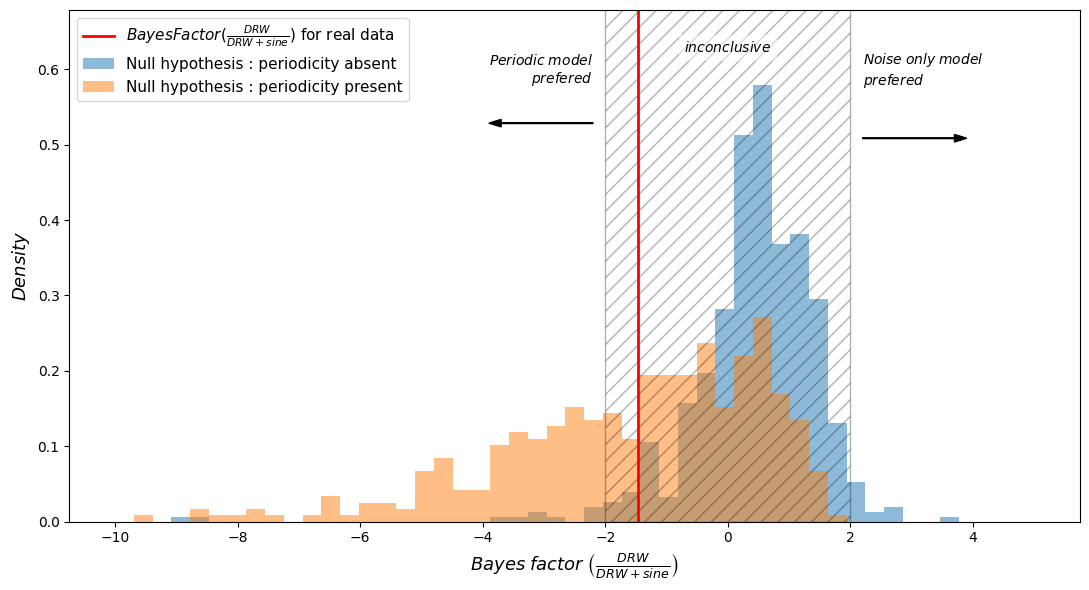

In [67]:
if True:
    # density = gaussian_kde(np.log10(test['OBPL10_OBPLsine10_bayes']))

    plt.figure(figsize=[11,6])
    # xs = np.linspace(-3,3,200)
    # density.covariance_factor = lambda : .5
    # density._compute_covariance()
    
    
    plt.axvline(np.log10(org_DRW_DRWsine_bayes_factor), color = 'r', lw = 2, label = r'$BayesFactor(\frac{DRW}{DRW + sine})$ for real data')
    #plt.axvline(np.log10(org_DRW_DRWsine_bayes_factor), color = 'b', lw = 2, label = 'DRW bayes factor')
    #plt.axvline(np.log10(org_CARMA21_CARMA21sine_bayes_factor), color = 'g', lw = 2, label = 'CARMA21 bayes factor')

    #plt.plot(xs,density(xs), 'k--', label = 'Gaussian KDE')
    counts1 = plt.hist(np.log10(Bayes_test_nosinehyp['DRW_DRWsine_bayes']), bins = np.linspace(-10, 5, 50), density=True, label = 'Null hypothesis : periodicity absent', alpha = 0.5)
    counts2 = plt.hist(np.log10(Bayes_test_sinehyp['DRW_DRWsine_bayes']), bins = np.linspace(-10, 5, 50), density=True, label = 'Null hypothesis : periodicity present', alpha = 0.5)
#     line_styles = [plt.Line2D([0], [0], color='k', linestyle='-'),
#                 plt.Line2D([0], [0], color='k', linestyle='--')]
#     line_style_labels = ['orginal data', 'sim data :  gaussian kde']
#     colors = [plt.Line2D([0], [0], color='r', lw=4),
#             plt.Line2D([0], [0], color='b', lw=4),
#             plt.Line2D([0], [0], color='g', lw=4)]
#     color_labels = ['OBPL bayes factor', 'DRW bayes factor', 'CARMA21 bayes factor' ]

#     legend1 = plt.legend(line_styles, line_style_labels, loc='upper left', bbox_to_anchor=(0.005, 0.99))
#     legend2 = plt.legend(colors, color_labels, loc='upper left', bbox_to_anchor=(0.005, 0.86))

    # Add the first legend back to the plot
    plt.legend(loc = 'upper left', fontsize = 11)
    arrow_style = {
        "head_width": 0.01,
        "head_length": 0.2,
        "color":"k"
    }    
    
    plt.fill_betweenx(np.linspace(0, max(max(counts1[0]), max(counts2[0]))+1, 10), -2, 2, hatch = '//', facecolor ="none", alpha = 0.3)
    plt.text(0, max(max(counts1[0]), max(counts2[0]))+0.05, '$inconclusive$', fontsize = 10, horizontalalignment = 'center', verticalalignment = 'center',
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    
    plt.text(-2.2, max(max(counts1[0]), max(counts2[0]))+0.02, '$Periodic\; model$\n$prefered$',horizontalalignment = 'right', verticalalignment = 'center', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(-2.2, max(max(counts1[0]), max(counts2[0]))-0.05, -1.5, 0, **arrow_style)
    
    plt.text(2.2, max(max(counts1[0]), max(counts2[0]))+0.02, '$Noise\;only\; model$\n$prefered$',horizontalalignment = 'left', verticalalignment = 'center', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(2.2, max(max(counts1[0]), max(counts2[0]))-0.07, +1.5, 0, **arrow_style)
    
    plt.ylim(0, max(max(counts1[0]), max(counts2[0]))+0.1)
    plt.ylabel(r'$Density$', fontsize = 13)
    plt.xlabel(r'$Bayes\;factor\;\left(\frac{}{}\right)$'.format("{DRW}", "{DRW + sine }" ), fontsize =13)
    plt.tight_layout()
    plt.show()

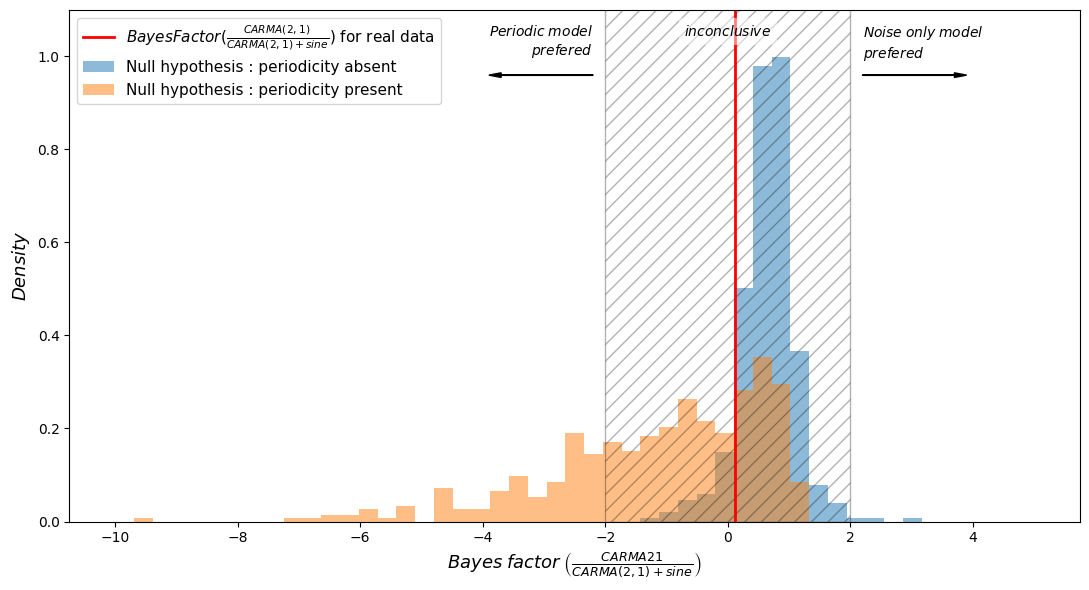

In [ ]:
if False:
    # density = gaussian_kde(np.log10(test['OBPL10_OBPLsine10_bayes']))

    plt.figure(figsize=[11,6])
    # xs = np.linspace(-3,3,200)
    # density.covariance_factor = lambda : .5
    # density._compute_covariance()
    
    plt.axvline(np.log10(org_DRW_DRWsine_bayes_factor), color = 'r', lw = 2, label = r'$BayesFactor(\frac{CARMA(2,1)}{CARMA(2,1) + sine})$ for real data')
    #plt.axvline(np.log10(org_DRW_DRWsine_bayes_factor), color = 'b', lw = 2, label = 'DRW bayes factor')
    #plt.axvline(np.log10(org_CARMA21_CARMA21sine_bayes_factor), color = 'g', lw = 2, label = 'CARMA21 bayes factor')

    #plt.plot(xs,density(xs), 'k--', label = 'Gaussian KDE')
    counts1 = plt.hist(np.log10(Bayes_test_nosinehyp['CARMA21_CARMA21sine_bayes']), bins = np.linspace(-10, 5, 50), density=True,label = 'Null hypothesis : periodicity absent', alpha = 0.5)
    counts2 = plt.hist(np.log10(Bayes_test_sinehyp['CARMA21_CARMA21sine_bayes']), bins = np.linspace(-10, 5, 50), density=True, label = 'Null hypothesis : periodicity present', alpha = 0.5)

#     line_styles = [plt.Line2D([0], [0], color='k', linestyle='-'),
#                 plt.Line2D([0], [0], color='k', linestyle='--')]
#     line_style_labels = ['orginal data', 'sim data :  gaussian kde']
#     colors = [plt.Line2D([0], [0], color='r', lw=4),
#             plt.Line2D([0], [0], color='b', lw=4),
#             plt.Line2D([0], [0], color='g', lw=4)]
#     color_labels = ['OBPL bayes factor', 'DRW bayes factor', 'CARMA21 bayes factor' ]

#     legend1 = plt.legend(line_styles, line_style_labels, loc='upper left', bbox_to_anchor=(0.005, 0.99))
#     legend2 = plt.legend(colors, color_labels, loc='upper left', bbox_to_anchor=(0.005, 0.86))

    # Add the first legend back to the plot
    plt.legend(loc = 'upper left', fontsize = 11)
    arrow_style = {
        "head_width": 0.01,
        "head_length": 0.2,
        "color":"k"
    }    
    plt.fill_betweenx(np.linspace(0, max(max(counts1[0]), max(counts2[0]))+1, 10), -2, 2, hatch = '//', facecolor ="none", alpha = 0.3)

    plt.text(0, max(max(counts1[0]), max(counts2[0]))+0.07, '$inconclusive$', fontsize = 10, horizontalalignment = 'center', verticalalignment = 'top',
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    
    plt.text(-2.2, max(max(counts1[0]), max(counts2[0]))+0.07, '$Periodic\; model$\n$prefered$',horizontalalignment = 'right', verticalalignment = 'top', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(-2.2, max(max(counts1[0]), max(counts2[0]))-0.04, -1.5, 0, **arrow_style)
    
    plt.text(2.2, max(max(counts1[0]), max(counts2[0]))+0.07, '$Noise\;only\; model$\n$prefered$',horizontalalignment = 'left', verticalalignment = 'top', fontsize = 10,
             bbox = dict(facecolor = 'white', edgecolor = 'none', alpha = 0.5))
    plt.arrow(2.2, max(max(counts1[0]), max(counts2[0]))-0.04, +1.5, 0, **arrow_style)
    
    plt.ylim(0, max(max(counts1[0]), max(counts2[0]))+0.1)
    plt.ylabel(r'$Density$', fontsize = 13)
    plt.xlabel(r'$Bayes\;factor\;\left(\frac{}{}\right)$'.format("{CARMA21}", "{CARMA(2,1) + sine }" ), fontsize =13)
    plt.tight_layout()
    plt.show()

# All analysis


In [3]:
FERMI_filenames = glob.glob('AGNobsdata/4FGL*.txt')
sourceID = []
for val in FERMI_filenames:
    sourceID.append(val[16:28])
folder_path = []
for val in FERMI_filenames:
    folder_path.append('real_data_tests/'+val[16:28]+'/')
    

In [4]:
analysis_data = pd.DataFrame({'SOURCEID':sourceID, 'FERMI_filenames': FERMI_filenames, 'folder_path':folder_path})
analysis_data

,SOURCEID,FERMI_filenames,folder_path
0,J0211.2+1051,AGNobsdata/4FGL_J0211.2+1051.txt,real_data_tests/J0211.2+1051/
1,J0043.8+3425,AGNobsdata/4FGL_J0043.8+3425.txt,real_data_tests/J0043.8+3425/
2,J0210.7-5101,AGNobsdata/4FGL_J0210.7-5101.txt,real_data_tests/J0210.7-5101/
3,J0303.4-2407,AGNobsdata/4FGL_J0303.4-2407.txt,real_data_tests/J0303.4-2407/
4,J0428.6-3756,AGNobsdata/4FGL_J0428.6-3756.txt,real_data_tests/J0428.6-3756/
5,J0449.4-4350,AGNobsdata/4FGL_J0449.4-4350.txt,real_data_tests/J0449.4-4350/
6,J0457.0-2324,AGNobsdata/4FGL_J0457.0-2324.txt,real_data_tests/J0457.0-2324/
7,J0501.2-0158,AGNobsdata/4FGL_J0501.2-0158.txt,real_data_tests/J0501.2-0158/
8,J0521.7+2112,AGNobsdata/4FGL_J0521.7+2112.txt,real_data_tests/J0521.7+2112/
9,J0721.9+7120,AGNobsdata/4FGL_J0721.9+7120.txt,real_data_tests/J0721.9+7120/


In [5]:
dict_dicts ={}
analysis_data[['DRW_log_Z', 'DRWsine_log_Z', 'CARMA_log_Z', 'CARMAsine_log_Z', 
               'OBPL_log_Z', 'OBPLsine_log_Z', 'log10_OBPL_OBPLsine_BF',
               'log10_DRW_DRWsine_BF', 'log10_CARMA_CARMAsine_BF']] = -99,-99,-99,-99,-99,-99,-99,-99,-99 
for i,row in analysis_data.iterrows():
    DRW_dict = load_json(row.folder_path + 'original_data_DRW.json')
    DRWsine_dict = load_json(row.folder_path +'original_data_DRWsine.json')

    CARMA_dict = load_json(row.folder_path +'original_data_CARMA21.json')
    CARMAsine_dict = load_json(row.folder_path +'original_data_CARMA21sine.json')

    OBPL_dict = load_json(row.folder_path +'original_data_OBPL10.json')
    OBPLsine_dict = load_json(row.folder_path +'original_data_OBPL10sine.json')
    dict_dicts[row.SOURCEID] = [DRW_dict, DRWsine_dict, CARMA_dict, CARMAsine_dict, OBPL_dict, OBPLsine_dict]
    
    analysis_data.loc[(analysis_data.SOURCEID == row.SOURCEID),'DRW_log_Z'] = DRW_dict['log_Z_mean']
    analysis_data.loc[(analysis_data.SOURCEID == row.SOURCEID),'DRWsine_log_Z'] = DRWsine_dict['log_Z_mean']
    analysis_data.loc[(analysis_data.SOURCEID == row.SOURCEID),'CARMA_log_Z'] = CARMA_dict['log_Z_mean']
    analysis_data.loc[(analysis_data.SOURCEID == row.SOURCEID),'CARMAsine_log_Z'] = CARMAsine_dict['log_Z_mean']
    analysis_data.loc[(analysis_data.SOURCEID == row.SOURCEID),'OBPL_log_Z'] = OBPL_dict['log_Z_mean']
    analysis_data.loc[(analysis_data.SOURCEID == row.SOURCEID),'OBPLsine_log_Z'] = OBPLsine_dict['log_Z_mean']
    
    analysis_data.loc[(analysis_data.SOURCEID == row.SOURCEID), 'log10_OBPL_OBPLsine_BF'] = np.log10(np.exp(OBPL_dict['log_Z_mean'] - OBPLsine_dict['log_Z_mean']))
    analysis_data.loc[(analysis_data.SOURCEID == row.SOURCEID), 'log10_DRW_DRWsine_BF'] = np.log10(np.exp(DRW_dict['log_Z_mean'] - DRWsine_dict['log_Z_mean']))
    analysis_data.loc[(analysis_data.SOURCEID == row.SOURCEID), 'log10_CARMA_CARMAsine_BF'] = np.log10(np.exp(CARMA_dict['log_Z_mean'] - CARMAsine_dict['log_Z_mean']))
    

In [7]:
analysis_data.sort_values(by='log10_OBPL_OBPLsine_BF', ascending=False)

,SOURCEID,FERMI_filenames,folder_path,DRW_log_Z,DRWsine_log_Z,CARMA_log_Z,CARMAsine_log_Z,OBPL_log_Z,OBPLsine_log_Z,log10_OBPL_OBPLsine_BF,log10_DRW_DRWsine_BF,log10_CARMA_CARMAsine_BF
12,J0818.2+4222,AGNobsdata/4FGL_J0818.2+4222.txt,real_data_tests/J0818.2+4222/,26.614325,21.205811,25.241289,19.910836,29.775217,23.963239,2.524110,2.348888,2.314986
19,J1903.2+5540,AGNobsdata/4FGL_J1903.2+5540.txt,real_data_tests/J1903.2+5540/,1.195595,-4.037323,2.762111,-3.142449,7.189136,1.491228,2.474570,2.272627,2.564318
1,J0043.8+3425,AGNobsdata/4FGL_J0043.8+3425.txt,real_data_tests/J0043.8+3425/,-56.505166,-63.034852,-57.799785,-62.457114,-53.557896,-59.219012,2.458592,2.835806,2.022652
18,J1649.4+5235,AGNobsdata/4FGL_J1649.4+5235.txt,real_data_tests/J1649.4+5235/,-54.683409,-59.719912,-54.480984,-58.481619,-52.133912,-57.785672,2.454528,2.187325,1.737454
15,J1303.0+2434,AGNobsdata/4FGL_J1303.0+2434.txt,real_data_tests/J1303.0+2434/,-72.815312,-78.310416,-74.018123,-80.185205,-69.456782,-75.087337,2.445319,2.386493,2.678330
16,J1454.4+5124,AGNobsdata/4FGL_J1454.4+5124.txt,real_data_tests/J1454.4+5124/,-47.443310,-52.785673,-48.769799,-53.731912,-42.034365,-47.501833,2.374491,2.320159,2.155018
3,J0303.4-2407,AGNobsdata/4FGL_J0303.4-2407.txt,real_data_tests/J0303.4-2407/,-69.255984,-74.384428,-72.714462,-77.421064,-66.800795,-71.831339,2.184737,2.227255,2.044051
0,J0211.2+1051,AGNobsdata/4FGL_J0211.2+1051.txt,real_data_tests/J0211.2+1051/,-49.162248,-53.329470,-51.262848,-57.821335,-45.145971,-49.812161,2.026501,1.809802,2.848315
5,J0449.4-4350,AGNobsdata/4FGL_J0449.4-4350.txt,real_data_tests/J0449.4-4350/,-35.768332,-40.742592,-39.297997,-43.740889,-34.869447,-39.468181,1.997205,2.160294,1.929523
20,J2056.2-4714,AGNobsdata/4FGL_J2056.2-4714.txt,real_data_tests/J2056.2-4714/,-121.012984,-124.856629,-122.457853,-126.453335,-116.528934,-120.487804,1.719315,1.669274,1.735216


In [37]:
def lognormal_curve(x, mean=0, sigma=1, num_points=1000):
    
    # Compute the probability density function (pdf)
    pdf = lognorm.pdf(x, sigma, scale=np.exp(mean))
    
    return pdf

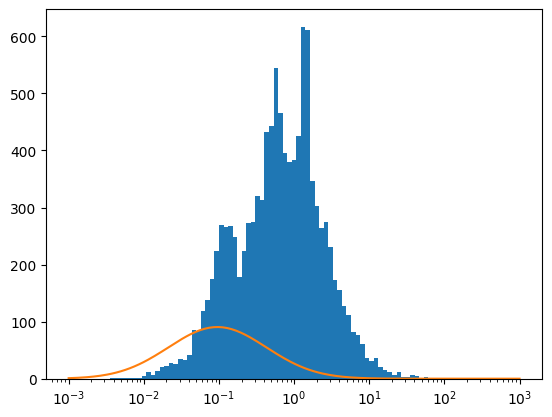

In [46]:
plt.hist(dict_dicts['J1555.7+1111'][5]['scales'], bins = np.logspace(-3, 3, 100), density=False, stacked=True)
plt.plot(np.logspace(-3, 3, 200), lognormal_curve(np.logspace(-3, 3, 200), -0.1, 1.5)*100)
plt.xscale('log')
plt.show()

{'A1': 0.14699557423353457, 'A2': -0.10095639828784311, 'alpha_h': 1.53194021802963, 'alpha_l': 0.8611957970276912, 'amp': 4.710948446110086, 'err_scale': 0.26164935703841596, 'scales': 0.6603345596492667, 't0': 2.158684876057131}


Plotting samples from posteriors... :   0%|          | 0/10 [00:00<?, ?it/s]WARNING:jax._src.xla_bridge:An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Plotting samples from posteriors... : 100%|██████████| 10/10 [04:04<00:00, 24.48s/it]


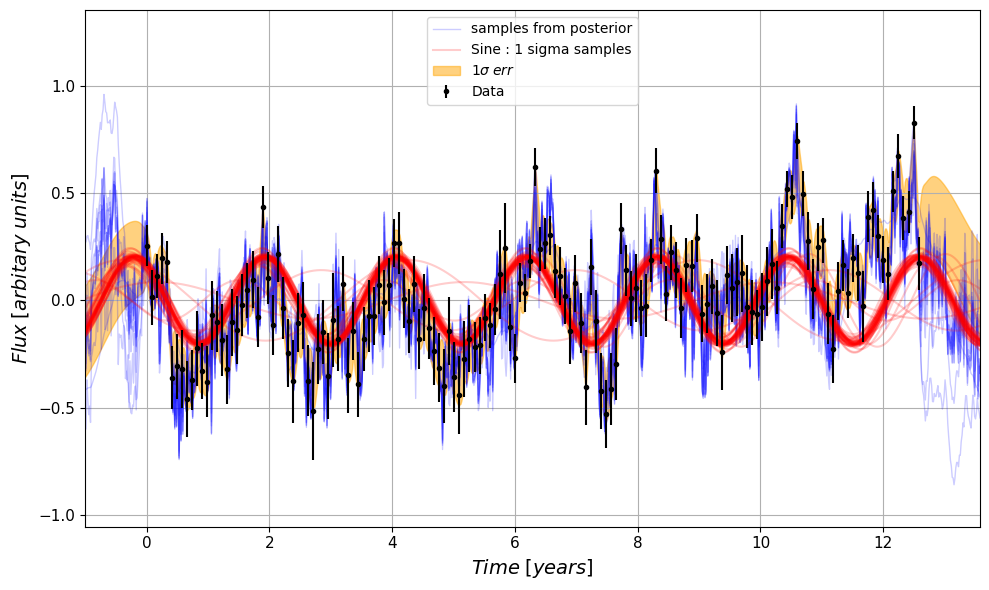

In [13]:
time, flux, fluxerr = np.loadtxt('AGNobsdata/4FGL_J1555.7+1111.txt').T
flux = flux - np.median(flux)

LC_GP_plotter(dict_dicts['J1555.7+1111'][5], time,flux,fluxerr, plot_what='OBPLsine' )

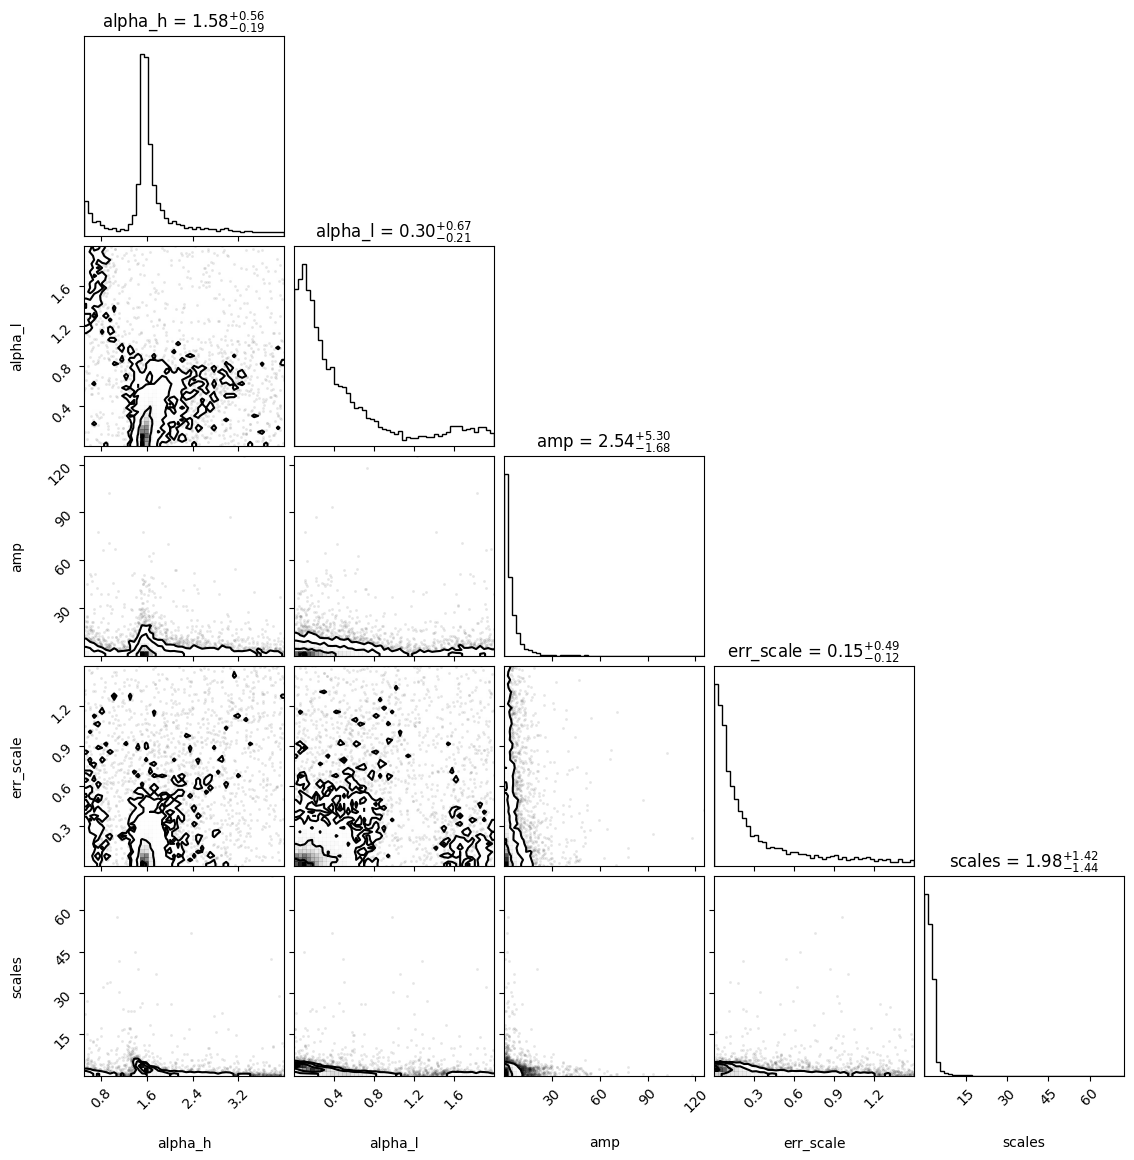

In [9]:
plot_corner(dict_dicts['J1555.7+1111'][5])